# ROMY - Barometer

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np

from pandas import DataFrame
from obspy import read_inventory
from scipy.signal import hilbert

from andbro__read_sds import __read_sds

In [2]:
from functions.get_mean_promy_pressure import __get_mean_promy_pressure
from functions.get_mean_rmy_pressure import __get_mean_rmy_pressure

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

## Configurations

In [59]:
config = {}

# output path for figures
config['path_to_figs'] = data_path+"romy_baro/figures/"

# path to data archive
config['path_to_data'] = data_path+"romy_events/data/"

# path to data sds
config['path_to_sds'] = archive_path+"temp_archive/"
config['path_to_sds2'] = bay_path+"mseed_online/archive/"


# adjust time interval
# example 1
# config['t1'] = obs.UTCDateTime("2024-03-04 05:00")
# config['t2'] = obs.UTCDateTime("2024-03-04 07:00")
# config['toffset'] = 3*3600

# example 2
# config['t1'] = obs.UTCDateTime("2024-04-23 02:00")
# config['t2'] = obs.UTCDateTime("2024-04-23 05:00")
# config['toffset'] = 3*3600

# example 3
config['t1'] = obs.UTCDateTime("2024-09-04 16:00")
config['t2'] = obs.UTCDateTime("2024-09-04 20:00")
config['toffset'] = 3*3600

# example 4
config['t1'] = obs.UTCDateTime("2024-02-10 03:00")
config['t2'] = obs.UTCDateTime("2024-02-10 07:00")
config['toffset'] = 3*3600

# example 5
config['t1'] = obs.UTCDateTime("2024-02-25 19:00")
config['t2'] = obs.UTCDateTime("2024-02-25 22:00")
config['toffset'] = 3*3600

# data
config['tbeg'] = config['t1'] - config['toffset']
config['tend'] = config['t2'] + config['toffset']

# ROMY coordinates
config['sta_lon'] = 11.275501
config['sta_lat'] = 48.162941

config['loc'] = "40"

## Load Data

In [60]:
# st0 = obs.read(config['path_to_data']+config['filename'], starttime=config['t1'], endtime=config['t2'])

# st0

In [61]:
st0 = obs.Stream()

st0 += __read_sds(config['path_to_sds'], f"BW.ROMY.{config['loc']}.BJZ", config['tbeg'], config['tend'])
st0 += __read_sds(config['path_to_sds'], f"BW.ROMY.{config['loc']}.BJN", config['tbeg'], config['tend'])
st0 += __read_sds(config['path_to_sds'], f"BW.ROMY.{config['loc']}.BJE", config['tbeg'], config['tend'])

st0 = st0.detrend("demean")
st0 = st0.detrend("linear")

# st0 = st0.merge(fill_value="interpolate")
# st0 = st0.merge(fill_value=np.nan)
st0 = st0.merge(fill_value=0)

st0

3 Trace(s) in Stream:
BW.ROMY.40.BJZ | 2024-02-25T15:59:59.987200Z - 2024-02-26T00:59:59.987200Z | 20.0 Hz, 648001 samples
BW.ROMY.40.BJE | 2024-02-25T15:59:59.980999Z - 2024-02-26T00:59:59.980999Z | 20.0 Hz, 648001 samples
BW.ROMY.40.BJN | 2024-02-25T16:00:00.014601Z - 2024-02-26T01:00:00.014601Z | 20.0 Hz, 648001 samples

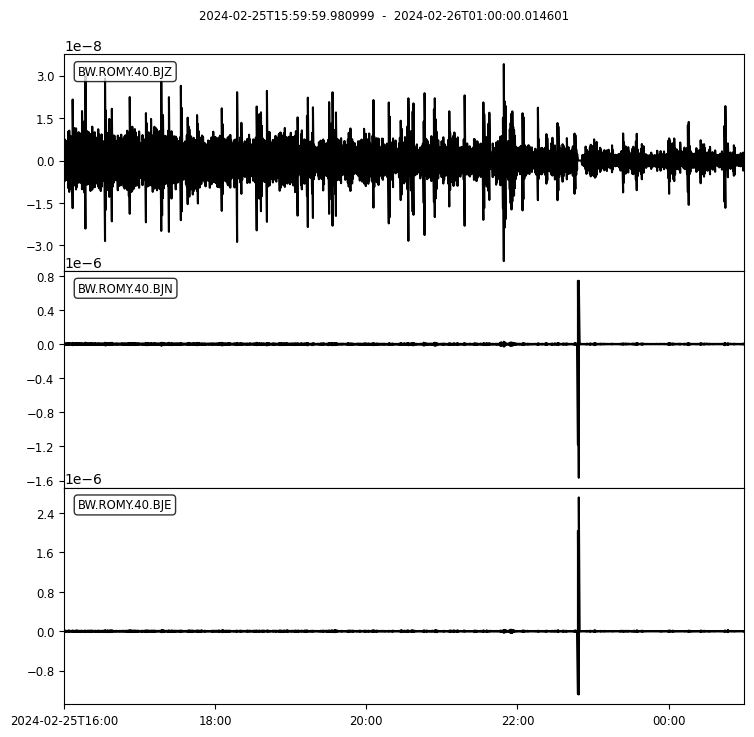

In [62]:
st0.plot(equal_scale=False);

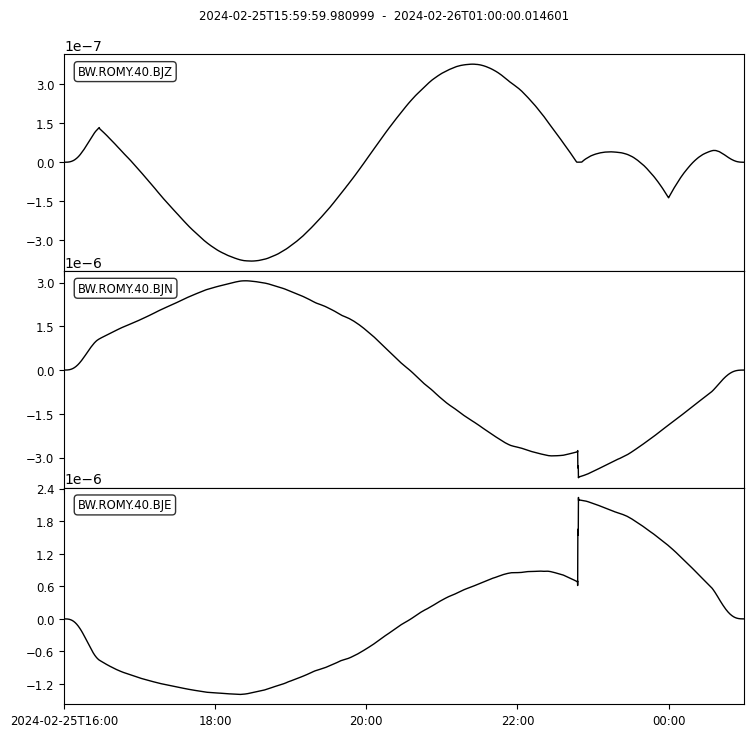

In [63]:
from scipy import integrate

til1 = st0.select(station=f"ROMY", channel="*J*").copy()

til1 = til1.detrend("demean")

til1 = til1.integrate("spline")
# til1 = til1.integrate("cumtrapz")

# for _tr in til1:
#     _tr.data = integrate.cumulative_simpson(_tr.data, dx=_tr.stats.delta)

til1 = til1.taper(0.05)
til1 = til1.filter("lowpass", freq=0.1, corners=4, zerophase=True)

til1 = til1.decimate(2, no_filter=True)
til1 = til1.decimate(10, no_filter=True)

til1.plot(equal_scale=False);

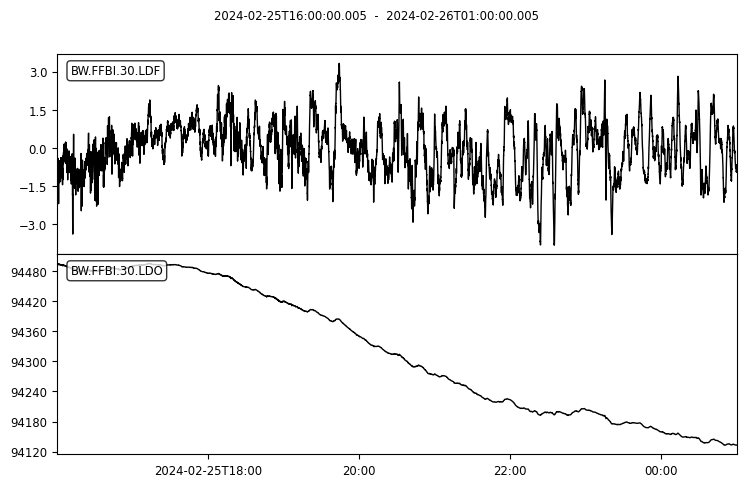

In [64]:
ffbi_inv = read_inventory(root_path+"/Documents/ROMY/ROMY_infrasound/station_BW_FFBI.xml")

ffbi0 = __read_sds(archive_path+"temp_archive/", "BW.FFBI.30.LDF", config['tbeg'], config['tend'])
ffbi0 += __read_sds(archive_path+"temp_archive/", "BW.FFBI.30.LDO", config['tbeg'], config['tend'])

# to pascal
for tr in ffbi0:
    if "O" in tr.stats.channel:
        tr.data *= 100

ffbi0.merge();

ffbi0.plot(equal_scale=False);

BW.WROMY.04.LDI | 2024-02-25T16:00:00.000000Z - 2024-02-26T01:00:00.000000Z | 1.0 Hz, 32401 samples
BW.WROMY.05.LDI | 2024-02-25T16:00:00.000000Z - 2024-02-26T01:00:00.000000Z | 1.0 Hz, 32401 samples
BW.WROMY.07.LDI | 2024-02-25T16:00:00.000000Z - 2024-02-26T01:00:00.000000Z | 1.0 Hz, 32401 samples
BW.WROMY.09.LDI | 2024-02-25T16:00:00.000000Z - 2024-02-26T01:00:00.000000Z | 1.0 Hz, 32401 samples


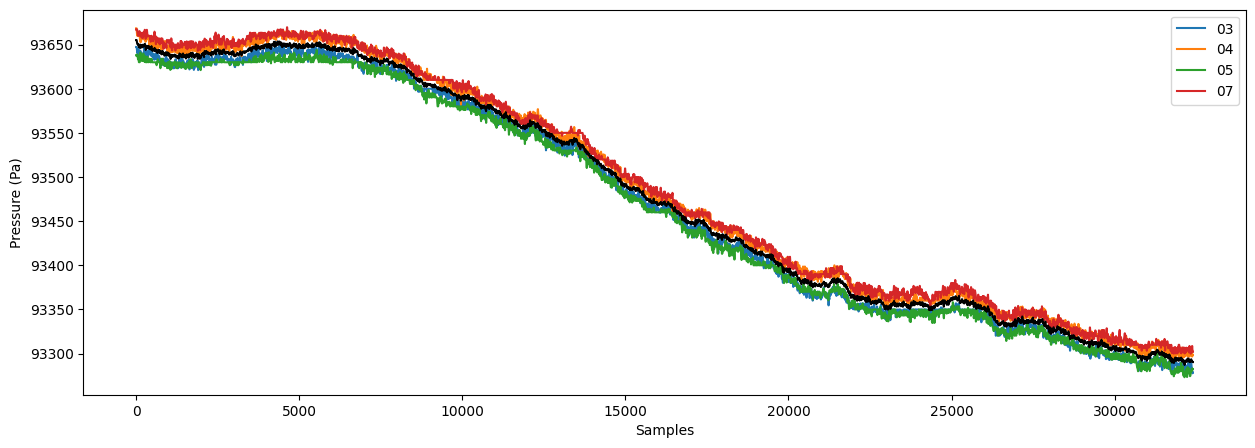

In [65]:
promy = __get_mean_promy_pressure(["03", "04", "05", "07", "09"], config['tbeg'], config['tend'], archive_path, plot=True)

In [66]:
def __get_mean_rmy_pressure(stations, t1, t2, path_to_data, plot=False):

    import matplotlib.pyplot as plt
    from andbro__read_sds import __read_sds
    from obspy import Stream
    from functions.interpolate_nan import __interpolate_nan
    from functions.smoothing import __smooth
    from obspy.signal.cross_correlation import correlate, xcorr_max
    from numpy import arange, roll, array

    ps0 = Stream()

    for jj in stations:
        if jj == "PROMY":
            loc, cha = "03", "LDI"
        else:
            loc, cha = "", "LDO"

        ps0 += __read_sds(path_to_data+"temp_archive/", f"BW.{jj}.{loc}.{cha}", t1-10, t2+10)

    ps0 = ps0.trim(t1, t2)

    # update stations
    stations = []
    for tr in ps0:
        stations.append(tr.stats.station)

        # smooth data
        tr.data = __smooth(tr.data, 30)

    # convert from hPa to Pa
    for tr in ps0:
        if "03" in tr.stats.location:
            tr.data = __interpolate_nan(tr.data)
        else:
            tr.data = tr.data * 100 # scale to Pa
            tr.data = __interpolate_nan(tr.data)

    # equalize number of samples
    npts_min = ps0[0].stats.npts
    for tr in ps0:
        if tr.stats.npts < npts_min:
            npts_min
    for tr in ps0:
        diff = abs(tr.stats.npts - npts_min)
        if diff != 0:
            tr.data = tr.data[:-diff]

    print(ps0)

    ps0 = ps0.detrend("linear")
    ps0 = ps0.detrend("simple")
    ps0 = ps0.filter("highpass", freq=1/(6*3600), corners=4, zerophase=True);

    # shift traces to compute mean of array
    shifted = []

    for i, sta in enumerate(stations):

        if i == 0:
            arr0 = ps0.select(station=sta)[0].data
            shifted.append(arr0)
            continue
        else:
            arr1 = ps0.select(station=sta)[0].data

        Nshift = len(arr0)

        dt = ps0[0].stats.delta

        ccf1 = correlate(arr0, arr1, shift=Nshift, demean=False, normalize='naive', method='fft')

        cclags = arange(-Nshift, Nshift+1) * dt

        shift1, value1 = xcorr_max(ccf1)
        print(shift1, value1)

        arr1_shifted = roll(arr1, shift1)

        shifted.append(arr1_shifted)

        # compute mean
        _mean = array([])
        for i, arr in enumerate(shifted):
            if i == 0:
                _mean = arr
            else:
                _mean = _mean + arr

    mean = ps0[0].copy()
    mean.stats.station = "RMY"
    mean.stats.location = "00"
    mean.stats.channel = "LDO"
    mean.data = _mean/(i+1)

    # checkup plot
    if plot:
        times = ps0[0].times()/3600
        fig = plt.figure(figsize=(15, 5))
        for i, x in enumerate(shifted):
            plt.plot(times, x, label=stations[i], zorder=2)
        plt.plot(times, mean.data, "k", zorder=2)
        plt.legend()
        plt.grid(ls="--", color="grey", alpha=0.4)
        plt.ylabel("Pressure (Pa)", fontsize=12)
        plt.xlabel("Time (hour)", fontsize=12)
        plt.show();

    if plot:
        return mean, fig
    else:
        return mean, _

In [68]:
brmy, _ = __get_mean_rmy_pressure(["PROMY", "ALFT", "TON", "BIB", "GELB", "GRMB"],
                                  config['tbeg'], config['tend'],
                                  archive_path,
                                  plot=True,
                                 )

4 Trace(s) in Stream:
BW.PROMY.03.LDI | 2024-02-25T16:00:00.000000Z - 2024-02-26T01:00:00.000000Z | 1.0 Hz, 32401 samples
BW.ALFT..LDO    | 2024-02-25T16:00:00.000000Z - 2024-02-26T01:00:00.000000Z | 1.0 Hz, 32401 samples
BW.GELB..LDO    | 2024-02-26T00:00:00.000000Z - 2024-02-26T00:00:00.000000Z | 1.0 Hz, 0 samples
BW.GRMB..LDO    | 2024-02-25T16:00:00.000000Z - 2024-02-26T01:00:00.000000Z | 1.0 Hz, 32401 samples


ValueError: cannot reshape array of size 0 into shape (0)

8 Trace(s) in Stream:
BW.ROMY.40.BJZ  | 2024-02-25T15:59:59.987200Z - 2024-02-26T00:59:59.987200Z | 1.0 Hz, 32401 samples
BW.ROMY.40.BJE  | 2024-02-25T15:59:59.980999Z - 2024-02-26T00:59:59.980999Z | 1.0 Hz, 32401 samples
BW.ROMY.40.BJN  | 2024-02-25T16:00:00.014601Z - 2024-02-26T01:00:00.014601Z | 1.0 Hz, 32401 samples
BW.FFBI.30.LDF  | 2024-02-25T16:00:00.005000Z - 2024-02-26T01:00:00.005000Z | 1.0 Hz, 32401 samples
BW.FFBI.30.LDO  | 2024-02-25T16:00:00.005000Z - 2024-02-26T01:00:00.005000Z | 1.0 Hz, 32401 samples
BW.FFBI.30.LDH  | 2024-02-25T16:00:00.005000Z - 2024-02-26T01:00:00.005000Z | 1.0 Hz, 32401 samples
BW.PROMY.00.LDI | 2024-02-25T16:00:00.000000Z - 2024-02-26T01:00:00.000000Z | 1.0 Hz, 32401 samples
BW.RMY.00.LDO   | 2024-02-10T00:00:00.000000Z - 2024-02-10T10:00:00.000000Z | 1.0 Hz, 36001 samples


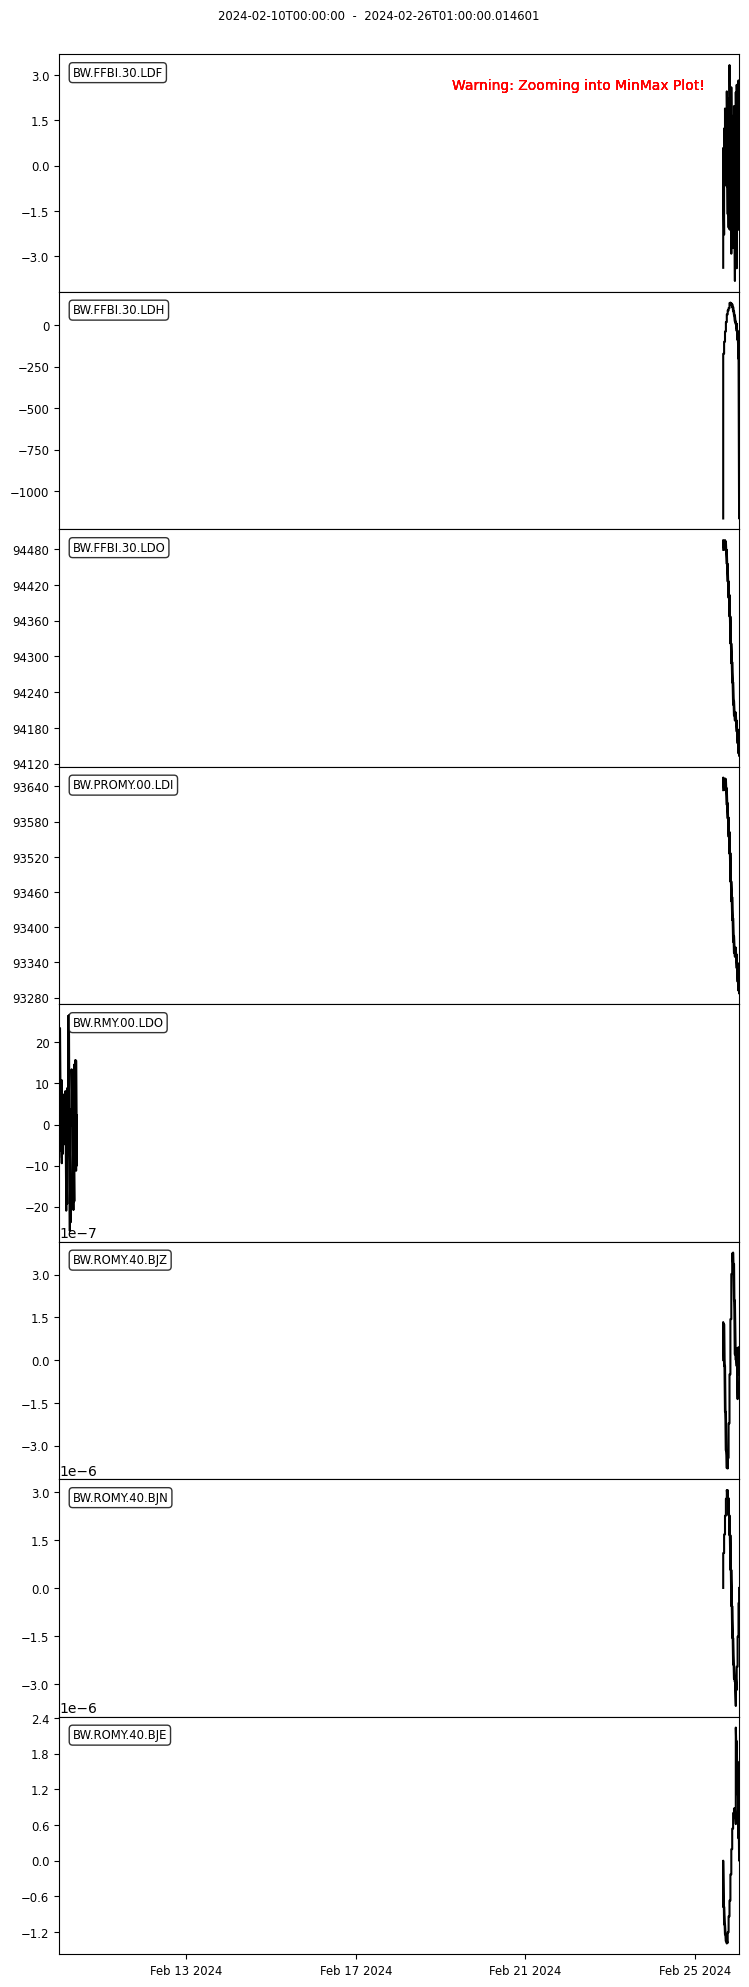

In [69]:
stt = obs.Stream()

stt += til1.copy()
stt += ffbi0.copy()

# add hilbert pressure
sth = ffbi0.select(channel="*O").copy()
for tr in sth:
    tr.data = np.imag(hilbert(tr.data))
    tr.stats.channel = "LDH"

stt += sth.copy()

# stt = stt.resample(10.0, no_filter=True)
# stt = stt.resample(1.0, no_filter=True)

try:
    stt += promy.copy()
except:
    pass
try:
    stt += brmy.copy()
except:
    pass

print(stt)

stt.plot(equal_scale=False);

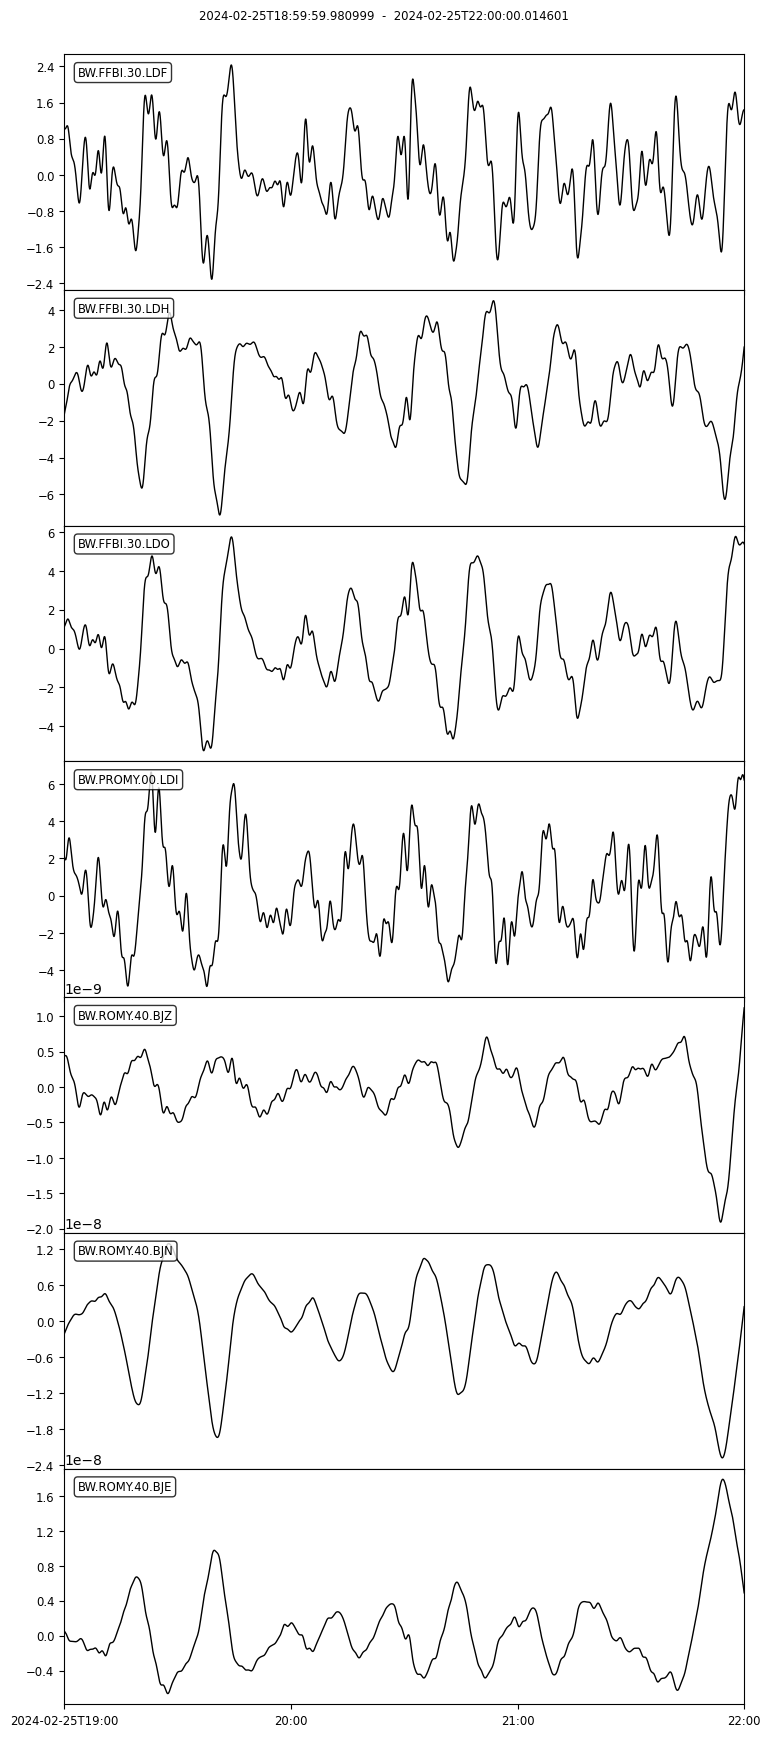

In [70]:
# fmin, fmax = 0.001, 0.01
# fmin, fmax = 0.001, 0.005
fmin, fmax = 0.0005, 0.01

stt = stt.detrend("demean")
stt = stt.detrend("linear")

stt = stt.taper(0.05)

stt = stt.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True);

stt = stt.trim(config['t1'], config['t2'])
stt = stt.trim(config['t1'], config['t2'])

for tr in til1:
    tr.data = tr.data[:-1]


stt.plot(equal_scale=False);


IndexError: list index out of range

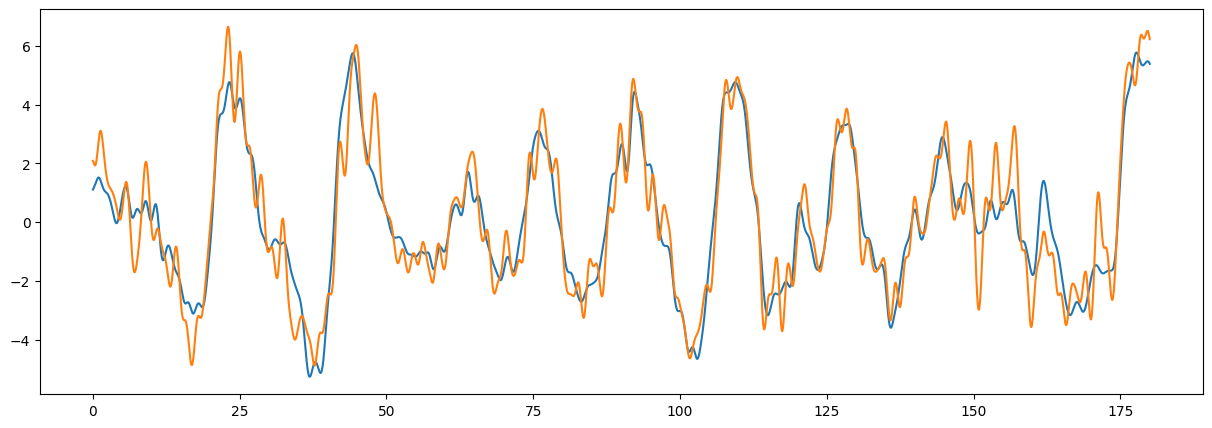

In [71]:
plt.figure(figsize=(15, 5))

tt = stt[0].times()/60

# plt.plot(tt, stt.select(channel="BDF")[0].data, label="FFBI.BDF")
plt.plot(tt, stt.select(channel="*DO")[0].data, label="FFBI.BDO")
plt.plot(tt, stt.select(station="PROMY")[0].data, label="PROMY.LDI")
plt.plot(tt, stt.select(station="RMY")[0].data, label="RMY.LDO")
plt.legend()
plt.ylabel("Pressure (Pa)")
plt.xlabel("Time (min)")
plt.show();

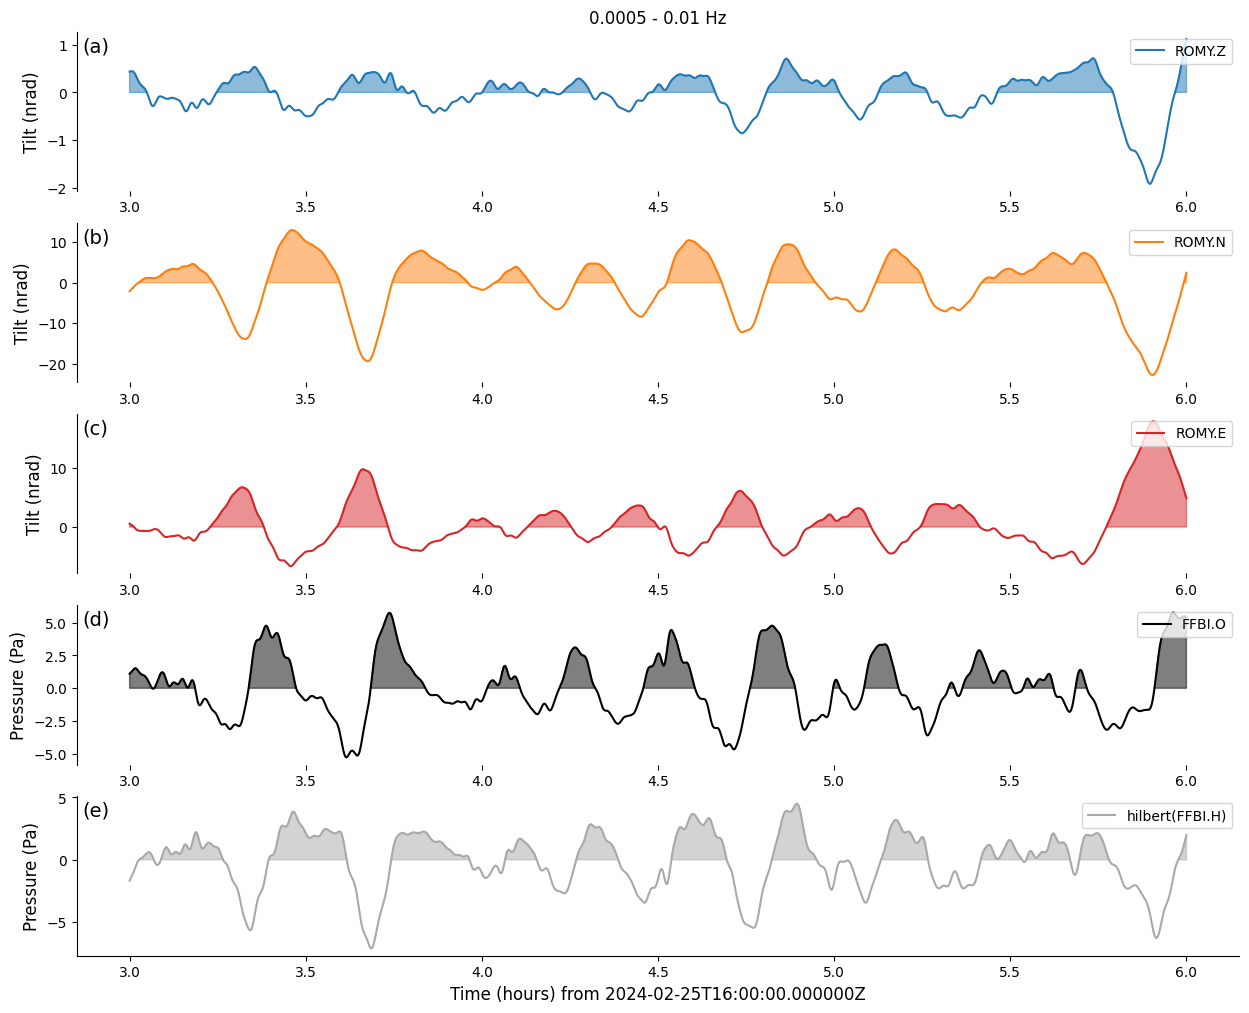

In [88]:
def __makeplot():

    from scipy.signal import hilbert
    from numpy import imag

    Nrow, Ncol = 5, 1

    yscale = 1e9

    font = 12

    ch = "*DO"

    tscale, tunit = 1/3600, "hours"

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 12))

    ax[0].plot(stt.select(component="Z")[0].times(reftime=config['tbeg'])*tscale,
               stt.select(component="Z")[0].data*yscale,
               label="ROMY.Z", color="tab:blue")

    ax[1].plot(stt.select(component="N")[0].times(reftime=config['tbeg'])*tscale,
               stt.select(component="N")[0].data*yscale,
               label="ROMY.N", color="tab:orange")

    ax[2].plot(stt.select(component="E")[0].times(reftime=config['tbeg'])*tscale,
               stt.select(component="E")[0].data*yscale,
               label="ROMY.E", color="tab:red")

    ax[3].plot(stt.select(channel="LDO")[0].times(reftime=config['tbeg'])*tscale,
               stt.select(channel="LDO")[0].data,
               label=f"FFBI.O", color="k")

    ax[4].plot(stt.select(channel="LDH")[0].times(reftime=config['tbeg'])*tscale,
               stt.select(channel="LDH")[0].data,
               label=f"hilbert(FFBI.H)", color="darkgrey")

    ax[0].fill_between(stt.select(component="Z")[0].times(reftime=config['tbeg'])*tscale, 0,
               stt.select(component="Z")[0].data*yscale,
               where=stt.select(component="Z")[0].data*yscale>0, interpolate=True,
               color="tab:blue", alpha=0.5)

    ax[1].fill_between(stt.select(component="N")[0].times(reftime=config['tbeg'])*tscale, 0,
               stt.select(component="N")[0].data*yscale,
               where=stt.select(component="N")[0].data*yscale>0, interpolate=True,
               color="tab:orange", alpha=0.5)

    ax[2].fill_between(stt.select(component="E")[0].times(reftime=config['tbeg'])*tscale, 0,
               stt.select(component="E")[0].data*yscale,
               where=stt.select(component="E")[0].data*yscale>0, interpolate=True,
               color="tab:red", alpha=0.5)

    ax[3].fill_between(stt.select(channel="LDO")[0].times(reftime=config['tbeg'])*tscale, 0,
               stt.select(channel="LDO")[0].data,
               where=stt.select(channel="LDO")[0].data>0, interpolate=True,
               color="k", alpha=0.5)

    ax[4].fill_between(stt.select(channel="LDH")[0].times(reftime=config['tbeg'])*tscale, 0,
               stt.select(channel="LDH")[0].data,
               where=stt.select(channel="LDH")[0].data>0, interpolate=True,
               color="darkgrey", alpha=0.5)

    for _n in range(Nrow):
        # ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)
        ax[_n].spines[['right', 'top']].set_visible(False)
        if _n < Nrow-1:
            ax[_n].spines[['bottom']].set_visible(False)

    ax[0].set_ylabel("Tilt (nrad)", fontsize=font)
    ax[1].set_ylabel("Tilt (nrad)", fontsize=font)
    ax[2].set_ylabel("Tilt (nrad)", fontsize=font)

    ax[3].set_ylabel("Pressure (Pa)", fontsize=font)
    ax[4].set_ylabel("Pressure (Pa)", fontsize=font)

    ax[Nrow-1].set_xlabel(f"Time ({tunit}) from {config['tbeg']}", fontsize=font)

    ax[0].set_title(f"{fmin} - {fmax} Hz")

    for _k, ll in enumerate(['(a)', '(b)', '(c)', '(d)', '(e)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"RB_{config['tbeg'].date}_waveforms.png", format="png", dpi=150, bbox_inches='tight')


In [73]:
def __makeplot():

    from scipy.signal import hilbert
    from numpy import imag

    Nrow, Ncol = 2, 2

    ch = "O"

    font = 12

    yscale = 1e9

    tscale, tunit = 1/3600, "hours"

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    ax[0, 0].scatter(imag(hilbert(stt.select(component=ch)[0].data)),
                    stt.select(component="N")[0].data*yscale,
                    label="ROMY-N", color="tab:orange", s=5
                    )
    ax[0, 0].set_xlabel("H(Pressure) (Pa)", fontsize=font)
    ax[0, 0].set_ylabel("Tilt (nrad)", fontsize=font)

    ax[0, 1].scatter(stt.select(component=ch)[0].data,
                    stt.select(component="N")[0].data*yscale,
                    label="ROMY-N", color="tab:orange", s=5,
                    )
    ax[0, 1].set_xlabel("Pressure (Pa)", fontsize=font)
    ax[0, 1].set_ylabel("Tilt (nrad)", fontsize=font)

    ax[1, 0].scatter(imag(hilbert(stt.select(component=ch)[0].data)),
                    stt.select(component="E")[0].data*yscale,
                    label="ROMY-E", color="tab:red", s=5
                    )
    ax[1, 0].set_xlabel("H(Pressure) (Pa)", fontsize=font)
    ax[1, 0].set_ylabel("Tilt (nrad)", fontsize=font)

    ax[1, 1].scatter(stt.select(component=ch)[0].data,
                    stt.select(component="E")[0].data*yscale,
                    label="ROMY-E", color="tab:red", s=5
                    )
    ax[1, 1].set_xlabel("Pressure (Pa)", fontsize=font)
    ax[1, 1].set_ylabel("Tilt (nrad)", fontsize=font)

    for j in range(2):
        for i in range(2):
            ax[i, j].grid(ls=":", zorder=0)
            ax[i, j].legend(loc=1)
            # ax[i, j].set_title(f"{fmin} - {fmax} Hz", fontsize=font)

    plt.show();
    return fig

# fig = __makeplot();

# fig.savefig("/home/andbro/Desktop/FürRuedi/"+"waveforms_scatter.png")

Nshift:  289 Tshift:  289.0 CC:  -0.8039564910124811
Nshift:  313 Tshift:  313.0 CC:  0.6938835452115723


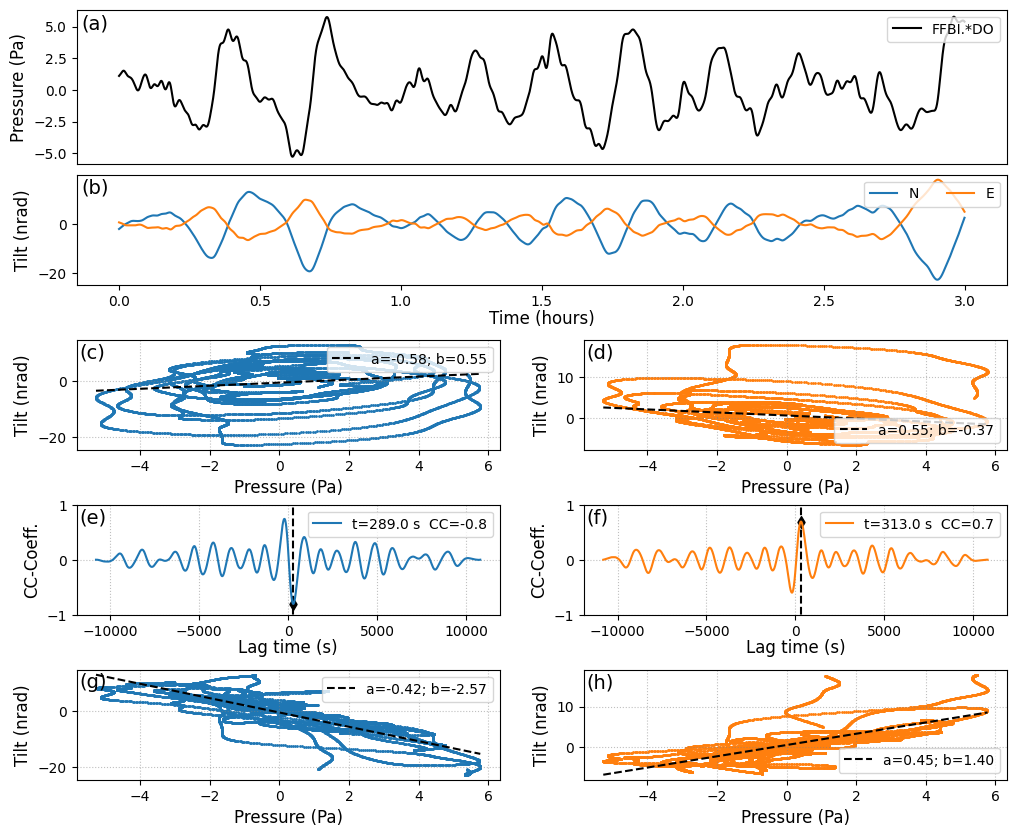

In [74]:
def __compare_tilt_pressure(st0):

    from obspy.signal.cross_correlation import correlate, xcorr_max
    from numpy import nan_to_num, arange, array, linspace, imag, roll
    from matplotlib.gridspec import GridSpec
    from functions.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression
    from functions.smoothing import __smooth
    from scipy.signal import hilbert

    tlp = st0.copy()

    dt = tlp[0].stats.delta

    times = tlp[0].times()/3600

    ch = "*DO"

    arr0 = tlp.select(channel=ch)[0].data
    arr1 = tlp.select(component="N")[0].data
    arr2 = tlp.select(component="E")[0].data


    Nshift = len(arr0)

    ccf1 = correlate(arr0, arr1, shift=Nshift, demean=False, normalize='naive', method='fft')
    ccf2 = correlate(arr0, arr2, shift=Nshift, demean=False, normalize='naive', method='fft')

    cclags = arange(-Nshift, Nshift+1) * dt

    shift1, value1 = xcorr_max(ccf1)
    shift2, value2 = xcorr_max(ccf2)

    arr1_shifted = roll(arr1, shift1)
    arr2_shifted = roll(arr2, shift2)

    print("Nshift: ", shift1, "Tshift: ", shift1*dt, "CC: ", value1)
    print("Nshift: ", shift2, "Tshift: ", shift2*dt, "CC: ", value2)


    b1, a1 = __compute_orthogonal_distance_regression(arr0, arr1, xerr=None, yerr=None, bx=None, by=None)
    b2, a2 = __compute_orthogonal_distance_regression(arr0, arr2, xerr=None, yerr=None, bx=None, by=None)

    b1_shifted, a1_shifted = __compute_orthogonal_distance_regression(arr0, arr1_shifted, xerr=None, yerr=None, bx=None, by=None)
    b2_shifted, a2_shifted = __compute_orthogonal_distance_regression(arr0, arr2_shifted, xerr=None, yerr=None, bx=None, by=None)

    xxx = linspace(arr0.min(), arr0.max(), 100)

    Nrow, Ncol = 5, 2
    font = 12

    fig = plt.figure(figsize=(12, 10))

    gs0 = GridSpec(Nrow, Ncol, figure=fig, hspace=0)
    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.5)

    ax1 = fig.add_subplot(gs0[0, :])
    ax2 = fig.add_subplot(gs[1, :])
    ax3 = fig.add_subplot(gs[2, :1])
    ax4 = fig.add_subplot(gs[2, 1:])
    ax5 = fig.add_subplot(gs[3, :1])
    ax6 = fig.add_subplot(gs[3, 1:])
    ax7 = fig.add_subplot(gs[4, :1])
    ax8 = fig.add_subplot(gs[4, 1:])

    axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
    for _k, (ax, ll) in enumerate(zip(axes, ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)'])):
        ax.text(.005, .97, ll, ha='left', va='top', transform=ax.transAxes, fontsize=font+2)

    plt.subplots_adjust(hspace=0.35)

    ax1.plot(times, arr0, color="black", label=f"FFBI.{ch}")
    ax1.set_ylabel("Pressure (Pa)", fontsize=font)
    ax1.get_xaxis().set_visible(False)
    ax1.legend(loc=1)

    ax2.plot(times, arr1*1e9, label="N")
    ax2.plot(times, arr2*1e9, label="E")
    ax2.legend(loc=1, ncol=2)
    ax2.set_ylabel("Tilt (nrad)", fontsize=font)
    ax2.set_xlabel("Time (hours)", fontsize=font, labelpad=1)


    ax3.scatter(arr0, arr1*1e9, color="tab:blue", s=1)
    ax3.plot(xxx, (a1+b1*xxx)*1e9, ls="--", color="k", label=f"a={a1*1e9:.2f}; b={b1*1e9:.2f}")
    ax3.set_xlabel("Pressure (Pa)", fontsize=font)
    ax3.set_ylabel("Tilt (nrad)", fontsize=font)
    ax3.legend(loc=1)

    ax4.scatter(arr0, arr2*1e9, color="tab:orange", s=1)
    ax4.plot(xxx, (a2+b2*xxx)*1e9, ls="--", color="k", label=f"a={a2*1e9:.2f}; b={b2*1e9:.2f}")
    ax4.set_xlabel("Pressure (Pa)", fontsize=font)
    ax4.set_ylabel("Tilt (nrad)", fontsize=font)
    ax4.legend(loc=4)

    ll = f"t={round(shift1*dt, 1)} s  CC={round(value1, 1)}"
    ax5.plot(cclags, ccf1, color="tab:blue", label=ll)
    ax5.set_ylabel("CC-Coeff.", fontsize=font)
    ax5.set_xlabel("Lag time (s)", fontsize=font, labelpad=0)
    ax5.set_ylim(-1, 1)
    ax5.axvline(shift1*dt, -1, 1, color="k", ls="--", zorder=0)
    ax5.scatter(shift1*dt, value1, color="k", marker="d", zorder=0)
    ax5.legend(loc=1)
    # ax5.text(.005, .97, ll, ha='left', va='top', transform=ax3.transAxes, fontsize=font)

    ll = f"t={round(shift2*dt, 1)} s  CC={round(value2, 1)}"
    ax6.plot(cclags, ccf2, color="tab:orange", label=ll)
    ax6.set_ylabel("CC-Coeff.", fontsize=font)
    ax6.set_xlabel("Lag time (s)", fontsize=font, labelpad=0)
    ax6.set_ylim(-1, 1)
    ax6.axvline(shift2*dt, -1, 1, color="k", ls="--", zorder=0)
    ax6.scatter(shift2*dt, value2, color="k", marker="d", zorder=0)
    ax6.legend(loc=1)
    # ax6.text(.005, .97, ll, ha='left', va='top', transform=ax4.transAxes, fontsize=font)


    ax7.scatter(arr0, arr1_shifted*1e9, color="tab:blue", s=1)
    ax7.plot(xxx, (a1_shifted+b1_shifted*xxx)*1e9, ls="--", color="k", label=f"a={a1_shifted*1e9:.2f}; b={b1_shifted*1e9:.2f}")
    ax7.set_xlabel("Pressure (Pa)", fontsize=font)
    ax7.set_ylabel("Tilt (nrad)", fontsize=font)
    ax7.legend(loc=1)

    ax8.scatter(arr0, arr2_shifted*1e9, color="tab:orange", s=1)
    ax8.plot(xxx, (a2_shifted+b2_shifted*xxx)*1e9, ls="--", color="k", label=f"a={a2_shifted*1e9:.2f}; b={b2_shifted*1e9:.2f}")
    ax8.set_xlabel("Pressure (Pa)", fontsize=font)
    ax8.set_ylabel("Tilt (nrad)", fontsize=font)
    ax8.legend(loc=4)

    for ax in [ax3, ax4, ax5, ax6, ax7, ax8]:
        ax.grid(ls=":", alpha=0.5, zorder=0, color="grey")

    plt.show();
    return fig

fig = __compare_tilt_pressure(stt)

# fig.savefig(config['path_to_figs']+f"RB__{config['tbeg'].date}_waveforms_cc.png", format="png", dpi=150, bbox_inches='tight')


Nshift:  37 Tshift:  37.0 CC:  0.9144353649716523
Nshift:  56 Tshift:  56.0 CC:  -0.7987798178981289


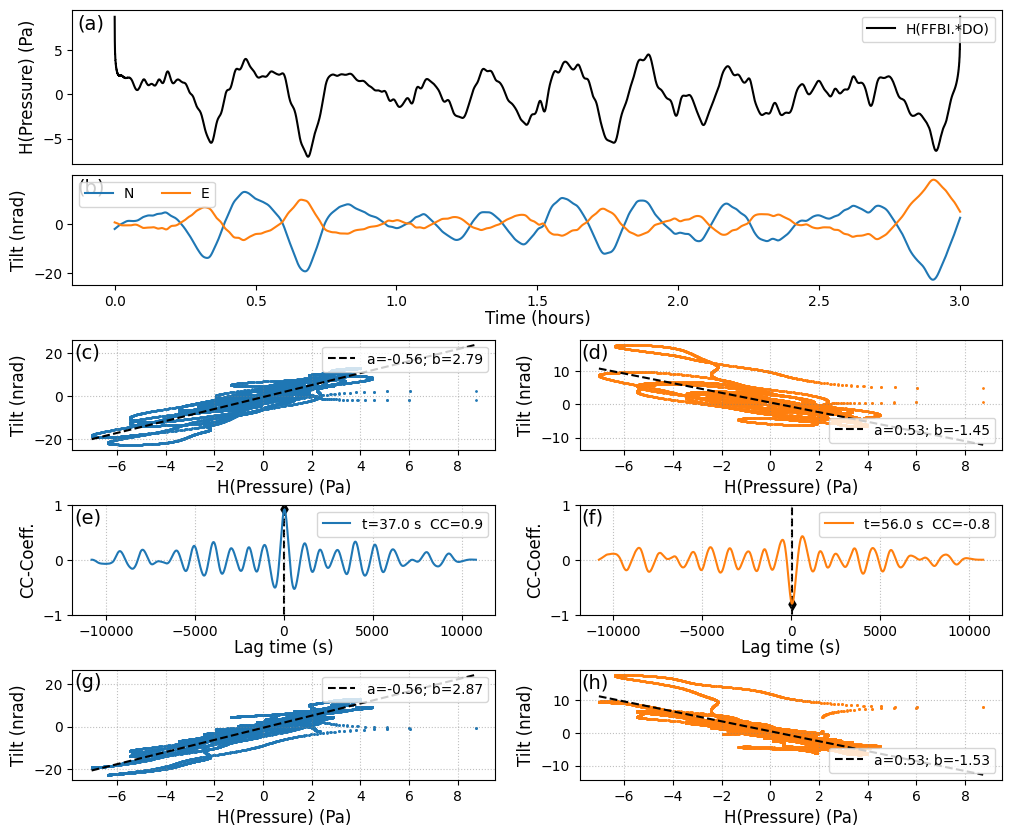

In [75]:
def __compare_tilt_pressure(st0):

    from obspy.signal.cross_correlation import correlate, xcorr_max
    from numpy import nan_to_num, arange, array, linspace, imag, roll
    from matplotlib.gridspec import GridSpec
    from functions.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression
    from functions.smoothing import __smooth
    from scipy.signal import hilbert

    tlp = st0.copy()

    dt = tlp[0].stats.delta

    times = tlp[0].times()/3600

    yscale = 1e9

    ch = "*DO"

    arr0 = imag(hilbert(tlp.select(channel=ch)[0].data))
    arr1 = tlp.select(component="N")[0].data
    arr2 = tlp.select(component="E")[0].data

    Nshift = len(arr0)

    ccf1 = correlate(arr0, arr1, shift=Nshift, demean=False, normalize='naive', method='fft')
    ccf2 = correlate(arr0, arr2, shift=Nshift, demean=False, normalize='naive', method='fft')

    cclags = arange(-Nshift, Nshift+1) * dt

    shift1, value1 = xcorr_max(ccf1)
    shift2, value2 = xcorr_max(ccf2)

    arr1_shifted = roll(arr1, shift1)
    arr2_shifted = roll(arr2, shift2)

    print("Nshift: ", shift1, "Tshift: ", shift1*dt, "CC: ", value1)
    print("Nshift: ", shift2, "Tshift: ", shift2*dt, "CC: ", value2)


    b1, a1 = __compute_orthogonal_distance_regression(arr0, arr1, xerr=None, yerr=None, bx=None, by=None)
    b2, a2 = __compute_orthogonal_distance_regression(arr0, arr2, xerr=None, yerr=None, bx=None, by=None)

    b1_shifted, a1_shifted = __compute_orthogonal_distance_regression(arr0, arr1_shifted, xerr=None, yerr=None, bx=None, by=None)
    b2_shifted, a2_shifted = __compute_orthogonal_distance_regression(arr0, arr2_shifted, xerr=None, yerr=None, bx=None, by=None)

    xxx = linspace(arr0.min(), arr0.max(), 100)

    Nrow, Ncol = 5, 2
    font = 12

    fig = plt.figure(figsize=(12, 10))

    gs0 = GridSpec(Nrow, Ncol, figure=fig, hspace=0)
    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.5)

    ax1 = fig.add_subplot(gs0[0, :])
    ax2 = fig.add_subplot(gs[1, :])
    ax3 = fig.add_subplot(gs[2, :1])
    ax4 = fig.add_subplot(gs[2, 1:])
    ax5 = fig.add_subplot(gs[3, :1])
    ax6 = fig.add_subplot(gs[3, 1:])
    ax7 = fig.add_subplot(gs[4, :1])
    ax8 = fig.add_subplot(gs[4, 1:])

    axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
    for _k, (ax, ll) in enumerate(zip(axes, ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)'])):
        ax.text(.005, .97, ll, ha='left', va='top', transform=ax.transAxes, fontsize=font+2)

    plt.subplots_adjust(hspace=0.35)

    ax1.plot(times, arr0, color="black", label=f"H(FFBI.{ch})")
    ax1.set_ylabel("H(Pressure) (Pa)", fontsize=font)
    ax1.get_xaxis().set_visible(False)
    ax1.legend(loc=1)

    ax2.plot(times, arr1*yscale, label="N")
    ax2.plot(times, arr2*yscale, label="E")
    ax2.legend(ncol=2)
    ax2.set_ylabel("Tilt (nrad)", fontsize=font)
    ax2.set_xlabel("Time (hours)", fontsize=font, labelpad=1)


    ax3.scatter(arr0, arr1*yscale, color="tab:blue", s=1)
    ax3.plot(xxx, (a1+b1*xxx)*yscale, ls="--", color="k", label=f"a={a1*1e9:.2f}; b={b1*yscale:.2f}")
    ax3.set_xlabel("H(Pressure) (Pa)", fontsize=font)
    ax3.set_ylabel("Tilt (nrad)", fontsize=font)
    ax3.legend(loc=1)

    ax4.scatter(arr0, arr2*yscale, color="tab:orange", s=1)
    ax4.plot(xxx, (a2+b2*xxx)*yscale, ls="--", color="k", label=f"a={a2*1e9:.2f}; b={b2*yscale:.2f}")
    ax4.set_xlabel("H(Pressure) (Pa)", fontsize=font)
    ax4.set_ylabel("Tilt (nrad)", fontsize=font)
    ax4.legend(loc=4)

    ll = f"t={round(shift1*dt, 1)} s  CC={round(value1, 1)}"
    ax5.plot(cclags, ccf1, color="tab:blue", label=ll)
    ax5.set_ylabel("CC-Coeff.", fontsize=font)
    ax5.set_xlabel("Lag time (s)", fontsize=font, labelpad=0)
    ax5.set_ylim(-1, 1)
    ax5.axvline(shift1*dt, -1, 1, color="k", ls="--", zorder=0)
    ax5.scatter(shift1*dt, value1, color="k", marker="d", zorder=0)
    ax5.legend(loc=1)
    # ax5.text(.005, .97, ll, ha='left', va='top', transform=ax3.transAxes, fontsize=font)

    ll = f"t={round(shift2*dt, 1)} s  CC={round(value2, 1)}"
    ax6.plot(cclags, ccf2, color="tab:orange", label=ll)
    ax6.set_ylabel("CC-Coeff.", fontsize=font)
    ax6.set_xlabel("Lag time (s)", fontsize=font, labelpad=0)
    ax6.set_ylim(-1, 1)
    ax6.axvline(shift2*dt, -1, 1, color="k", ls="--", zorder=0)
    ax6.scatter(shift2*dt, value2, color="k", marker="d", zorder=0)
    ax6.legend(loc=1)
    # ax6.text(.005, .97, ll, ha='left', va='top', transform=ax4.transAxes, fontsize=font)

    ax7.scatter(arr0, arr1_shifted*yscale, color="tab:blue", s=1)
    ax7.plot(xxx, (a1_shifted+b1_shifted*xxx)*yscale, ls="--", color="k", label=f"a={a1_shifted*yscale:.2f}; b={b1_shifted*1e9:.2f}")
    ax7.set_xlabel("H(Pressure) (Pa)", fontsize=font)
    ax7.set_ylabel("Tilt (nrad)", fontsize=font)
    ax7.legend(loc=1)

    ax8.scatter(arr0, arr2_shifted*yscale, color="tab:orange", s=1)
    ax8.plot(xxx, (a2_shifted+b2_shifted*xxx)*yscale, ls="--", color="k", label=f"a={a2_shifted*yscale:.2f}; b={b2_shifted*1e9:.2f}")
    ax8.set_xlabel("H(Pressure) (Pa)", fontsize=font)
    ax8.set_ylabel("Tilt (nrad)", fontsize=font)
    ax8.legend(loc=4)

    for ax in [ax3, ax4, ax5, ax6, ax7, ax8]:
        ax.grid(ls=":", alpha=0.5, zorder=0, color="grey")


    plt.show();
    return fig

fig = __compare_tilt_pressure(stt)

# fig.savefig(config['path_to_figs']+f"RB_{config['tbeg'].date}_waveforms_cc_hilbert.png", format="png", dpi=150, bbox_inches='tight')


## Estimate Linear Coefficients

In [89]:
def __estimate_linear_coefficients(st0, c1="N", c2="O", c3=None):

    from scipy.signal import hilbert
    from numpy import imag, array, linalg, vstack

    if c3 is None:
        c3 = c2

    # pressure
    pp = st0.select(channel=c2)[0].data

    # hilbert(pressure)
    hp = imag(hilbert(st0.select(channel=c3)[0].data))

    # data
    dd = st0.select(channel=c1)[0].data

    # matrix
    A = vstack([pp, hp]).T

    # least squares
    a, b = linalg.lstsq(A, dd, rcond=None)[0]

    # estimate of data
    hh = a*pp + b*hp

    # residual
    rr = dd - hh

    return a, b, hh, rr

In [90]:
def __variance_reduction(arr1, arr2):

    from numpy import var

    sig1 = var(arr1)
    sig2 = var(arr2)

    return round( (sig1 - sig2) / sig1 * 100, 2)

In [91]:
c2 = "*DO" # pressure
c3 = "*DO" # hilbert of pressure

a_Z, b_Z, hh_Z, res_Z = __estimate_linear_coefficients(stt, c1="BJZ", c2=c2, c3=c3)

# Vertical
dd_Z = stt.select(component="Z")[0].data
pp_Z = stt.select(channel=c2)[0].data

R_Z = __variance_reduction(dd_Z, res_Z)

tt_Z = stt.select(component="Z")[0].times()


# North
a_N, b_N, hh_N, res_N = __estimate_linear_coefficients(stt, c1="BJN", c2=c2, c3=c3)

dd_N = stt.select(component="N")[0].data
pp_N = stt.select(channel=c2)[0].data

R_N = __variance_reduction(dd_N, res_N)

tt_N = stt.select(component="N")[0].times()

# East
a_E, b_E, hh_E, res_E = __estimate_linear_coefficients(stt, c1="BJE", c2=c2, c3=c3)

dd_E = stt.select(component="E")[0].data
pp_E = stt.select(channel=c2)[0].data

R_E = __variance_reduction(dd_E, res_E)

tt_E = stt.select(component="E")[0].times()


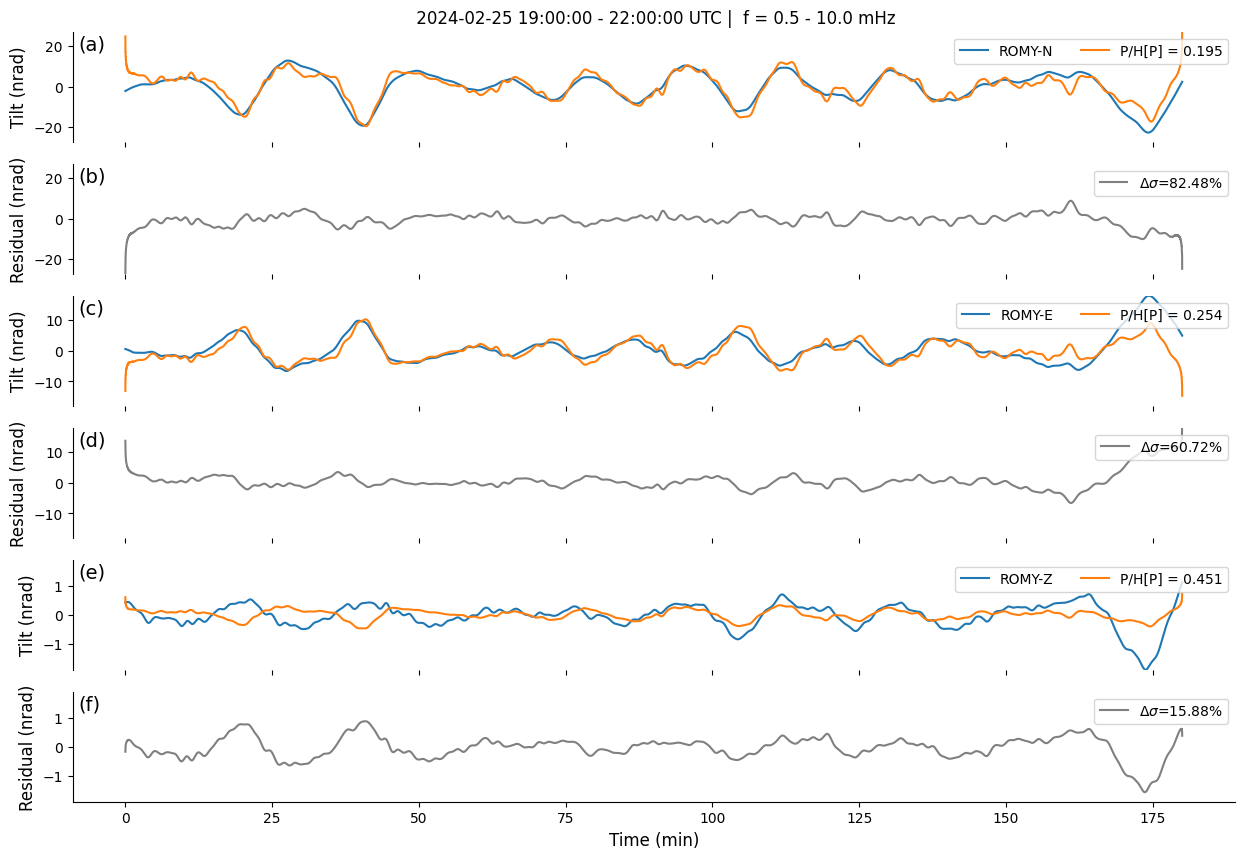

In [92]:
def __makeplot4():

    Nrow, Ncol = 6, 1

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    font = 12

    yscale, yunit = 1e9, "nrad"

    tscale, tunit = 1/60, "min"

    dsig = r"$\Delta \sigma$"

    y_max = max([max(abs(dd_N*yscale)), max(abs(hh_N*yscale))])

    ax[0].plot(tt_N*tscale, dd_N*yscale, label="ROMY-N")
    ax[0].plot(tt_N*tscale, hh_N*yscale, label=f"P/H[P] = {round(a_N/b_N, 3)}")
    # ax[0].plot(tt_N*tscale, hh_N*yscale, label=f"{round(a_N*1e12, 2)}e12 * P+{round(b_N*1e12, 2)}e12 * H[P]")
    ax[0].set_ylim(-y_max, y_max)
    ax[0].set_ylabel(f"Tilt ({yunit})", fontsize=font)

    ax[1].plot(tt_N*tscale, ( dd_N - hh_N )*yscale, color="grey", label=f"{dsig}={R_N}%")
    ax[1].set_ylim(-y_max, y_max)
    ax[1].set_ylabel(f"Residual ({yunit})", fontsize=font)


    y_max = max([max(abs(dd_E*yscale)), max(abs(hh_E*yscale))])

    ax[2].plot(tt_E*tscale, dd_E*yscale, label="ROMY-E")
    ax[2].plot(tt_E*tscale, hh_E*yscale, label=f"P/H[P] = {round(a_E/b_E, 3)}")
    ax[2].set_ylim(-y_max, y_max)
    ax[2].set_ylabel(f"Tilt ({yunit})", fontsize=font)

    ax[3].plot(tt_E*tscale, ( dd_E - hh_E )*yscale, color="grey", label=f"{dsig}={R_E}%")
    ax[3].set_ylim(-y_max, y_max)
    ax[3].set_ylabel(f"Residual ({yunit})", fontsize=font)


    y_max = max([max(abs(dd_Z*yscale)), max(abs(hh_Z*yscale))])

    ax[4].plot(tt_Z*tscale, dd_Z*yscale, label="ROMY-Z")
    ax[4].plot(tt_Z*tscale, hh_Z*yscale, label=f"P/H[P] = {round(a_Z/b_Z, 3)}")
    ax[4].set_ylim(-y_max, y_max)
    ax[4].set_ylabel(f"Tilt ({yunit})", fontsize=font)

    ax[5].plot(tt_Z*tscale, ( dd_Z - hh_Z )*yscale, color="grey", label=f"{dsig}={R_Z}%")
    ax[5].set_ylim(-y_max, y_max)
    ax[5].set_ylabel(f"Residual ({yunit})", fontsize=font)


    ax[Nrow-1].set_xlabel(f"Time ({tunit})", fontsize=font)

    ax[0].set_title(f" {config['t1'].date} {str(config['t1'].time).split('.')[0]} - {str(config['t2'].time).split('.')[0]} UTC |  f = {fmin*1e3} - {fmax*1e3} mHz", fontsize=font)

    for i in range(Nrow):
        ax[i].legend(loc=1, ncol=2)
        ax[i].spines[['right', 'top']].set_visible(False)
        if i < Nrow-1:
            ax[i].spines[['bottom']].set_visible(False)

    for _k, ll in enumerate(['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)


    plt.show();
    return fig

fig = __makeplot4()

# fig.savefig(config['path_to_figs']+f"RB_{config['tbeg'].date}_waveforms_corrected.png", format="png", dpi=150, bbox_inches='tight')


### Estimate Model

In [93]:
from functions.regression import __regression

In [94]:
def __regression(ddf, _features, target="fj_fs", reg="theilsen"):

    from sklearn import linear_model
    from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor
    from numpy import array

    _df = ddf.copy()

    # remove time and target
    try:
        _features.remove(target)
    except:
        pass
    try:
        _features.remove("time")
    except:
        pass

    print(_features)

    # define x data
    X = _df[_features].values.reshape(-1, len(_features))

    # define y data
    y = _df[target].values

    # multi linear regression

    # using OLS
    if reg.lower() == "ols":
        ols = linear_model.LinearRegression()
        model = ols.fit(X, y)

        print("R2:", model.score(X, y))
        print("X0:",  model.intercept_)
        print("Coef: ",  model.coef_)
        for _f, _c in zip(_features, model.coef_):
            print(f"{_f} : {_c}")

    elif reg.lower() == "ransac":
        model = RANSACRegressor(random_state=1).fit(X, y)
        print("R2:", model.score(X, y))
        print("IC: ", model.estimator_.intercept_)
        print("Coef: ",  model.estimator_.coef_)
        for _f, _c in zip(_features, model.estimator_.coef_):
            print(f"{_f} : {_c}")

    # using TheilSen
    elif reg.lower() == "theilsen":
        model = TheilSenRegressor().fit(X, y)

        print("R2:", model.score(X, y))
        print("X0:",  model.intercept_)
        print("Coef: ",  model.coef_)
        for _f, _c in zip(_features, model.coef_):
            print(f"{_f} : {_c}")

    # prediction
    model_predict = []

    for o, row in _df[_features].iterrows():

        x_pred = []
        for feat in _features:
            x_pred.append(row[feat])

        x_pred = array(x_pred)
        x_pred = x_pred.reshape(-1, len(_features))

        model_predict.append(model.predict(x_pred))

    # prepare putput dict
    out = {}

    out['model'] = model
    out['r2'] = model.score(X, y)
    out['tp'] = _df.time
    out['dp'] = model_predict

    if reg.lower() == "ransac":
        out['slope'] = model.estimator_.coef_
        out['inter'] = model.estimator_.intercept_
    elif reg.lower() == "theilsen":
        out['slope'] = model.coef_
        out['inter'] = model.intercept_
    elif reg.lower() == "ols":
        out['slope'] = model.coef_
        out['inter'] = model.intercept_

    # plt.plot(_df.time, model_predict)
    # plt.plot(_df.time, _df[target].values)

    return out

In [95]:
dff = DataFrame()

dff['time'] = stt[0].times()
dff['ffbPP'] = stt.select(station="FFBI", channel="*O")[0].data
dff['ffbHP'] = np.imag(hilbert(stt.select(station="FFBI", channel="*O")[0].data))

dff['rmyPP'] = stt.select(station="RMY", channel="*O")[0].data
dff['rmyHP'] = np.imag(hilbert(stt.select(station="RMY", channel="*O")[0].data))

for c in ["N", "E", "Z"]:
    dff[c] = stt.select(location=config['loc'], channel=f"*{c}")[0].data

# model Z ffbi
outZ = __regression(dff, ['ffbPP', 'ffbHP'], target='Z', reg='ransac')

xx_Z0 = outZ['slope'][0]*dff['ffbPP'] + outZ['slope'][1]*dff['ffbHP']
re_Z0 = dff['Z'] - xx_Z0
vr_Z0 = __variance_reduction(xx_Z0, dff['Z'] - xx_Z0)
ra_Z0 = round(outZ['slope'][0]/outZ['slope'][1], 3)

# model N ffbi
outN = __regression(dff, ['ffbPP', 'ffbHP'], target='N', reg='ransac')

xx_N0 = outN['slope'][0]*dff['ffbPP'] + outN['slope'][1]*dff['ffbHP']
re_N0 = dff['N'] - xx_N0
vr_N0 = __variance_reduction(xx_N0, dff['N'] - xx_N0)
ra_N0 = round(outN['slope'][0]/outN['slope'][1], 3)

# model E ffbi
outE = __regression(dff, ['ffbPP', 'ffbHP'], target='E', reg='ransac')

xx_E0 = outE['slope'][0]*dff['ffbPP'] + outE['slope'][1]*dff['ffbHP']
re_E0 = dff['E'] - xx_E0
vr_E0 = __variance_reduction(xx_E0, dff['E'] - xx_E0)
ra_E0 = round(outE['slope'][0]/outE['slope'][1], 3)


# model Z rmy
outZ = __regression(dff, ['rmyPP', 'rmyHP'], target='Z', reg='ransac')

xx_Z1 = outZ['slope'][0]*dff['rmyPP'] + outZ['slope'][1]*dff['rmyHP']
re_Z1 = dff['Z'] - xx_Z1
vr_Z1 = __variance_reduction(xx_Z1, dff['Z'] - xx_Z1)
ra_Z1 = round(outZ['slope'][0]/outZ['slope'][1], 3)

# model N rmy
outN = __regression(dff, ['rmyPP', 'rmyHP'], target='N', reg='ransac')

xx_N1 = outN['slope'][0]*dff['rmyPP'] + outN['slope'][1]*dff['rmyHP']
re_N1 = dff['N'] - xx_N1
vr_N1 = __variance_reduction(xx_N1, dff['N'] - xx_N1)
ra_N1 = round(outN['slope'][0]/outN['slope'][1], 3)

# model E rmy
outE = __regression(dff, ['rmyPP', 'rmyHP'], target='E', reg='ransac')

xx_E1 = outE['slope'][0]*dff['rmyPP'] + outE['slope'][1]*dff['rmyHP']
re_E1 = dff['E'] - xx_E1
vr_E1 = __variance_reduction(xx_E1, dff['E'] - xx_E1)
ra_E1 = round(outE['slope'][0]/outE['slope'][1], 3)


IndexError: list index out of range

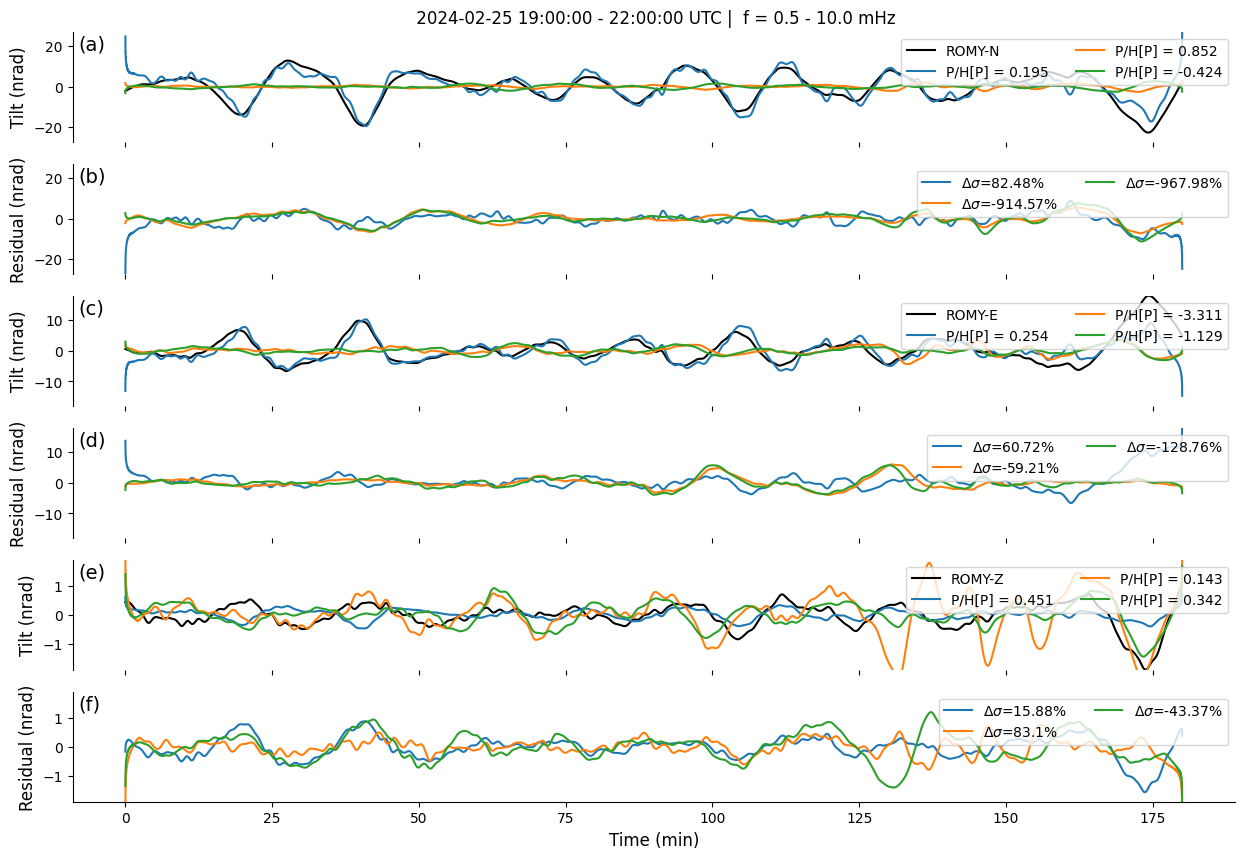

In [97]:
def __makeplot5():

    Nrow, Ncol = 6, 1

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    font = 12

    ls = "-"

    yscale, yunit = 1e9, "nrad"

    tscale, tunit = 1/60, "min"

    dsig = r"$\Delta \sigma$"

    y_max = max([max(abs(dd_N*yscale)), max(abs(hh_N*yscale))])

    ax[0].plot(tt_N*tscale, dd_N*yscale, label="ROMY-N", color="k")
    ax[0].plot(tt_N*tscale, hh_N*yscale, label=f"P/H[P] = {round(a_N/b_N, 3)}")
    ax[0].plot(tt_N*tscale, xx_N0*yscale, label=f"P/H[P] = {ra_N0}")
    ax[0].plot(tt_N*tscale, xx_N1*yscale, label=f"P/H[P] = {ra_N1}")
    ax[0].set_ylim(-y_max, y_max)
    ax[0].set_ylabel(f"Tilt ({yunit})", fontsize=font)

    ax[1].plot(tt_N*tscale, ( dd_N - hh_N )*yscale, label=f"{dsig}={R_N}%", ls=ls)
    ax[1].plot(tt_N*tscale, re_N0*yscale, label=f"{dsig}={vr_N0}%", ls=ls)
    ax[1].plot(tt_N*tscale, re_N1*yscale, label=f"{dsig}={vr_N1}%", ls=ls)
    ax[1].set_ylim(-y_max, y_max)
    ax[1].set_ylabel(f"Residual ({yunit})", fontsize=font)


    y_max = max([max(abs(dd_E*yscale)), max(abs(hh_E*yscale))])

    ax[2].plot(tt_E*tscale, dd_E*yscale, label="ROMY-E", color="k")
    ax[2].plot(tt_E*tscale, hh_E*yscale, label=f"P/H[P] = {round(a_E/b_E, 3)}")
    ax[2].plot(tt_E*tscale, xx_E0*yscale, label=f"P/H[P] = {ra_E0}")
    ax[2].plot(tt_E*tscale, xx_E1*yscale, label=f"P/H[P] = {ra_E1}")

    ax[2].set_ylim(-y_max, y_max)
    ax[2].set_ylabel(f"Tilt ({yunit})", fontsize=font)

    ax[3].plot(tt_E*tscale, ( dd_E - hh_E )*yscale, label=f"{dsig}={R_E}%", ls=ls)
    ax[3].plot(tt_E*tscale, re_E0*yscale, label=f"{dsig}={vr_E0}%", ls=ls)
    ax[3].plot(tt_E*tscale, re_E1*yscale, label=f"{dsig}={vr_E1}%", ls=ls)
    ax[3].set_ylim(-y_max, y_max)
    ax[3].set_ylabel(f"Residual ({yunit})", fontsize=font)


    y_max = max([max(abs(dd_Z*yscale)), max(abs(hh_Z*yscale))])

    ax[4].plot(tt_Z*tscale, dd_Z*yscale, label="ROMY-Z", color="k")
    ax[4].plot(tt_Z*tscale, hh_Z*yscale, label=f"P/H[P] = {round(a_Z/b_Z, 3)}")
    ax[4].plot(tt_Z*tscale, xx_Z0*yscale, label=f"P/H[P] = {ra_Z0}")
    ax[4].plot(tt_Z*tscale, xx_Z1*yscale, label=f"P/H[P] = {ra_Z1}")
    ax[4].set_ylim(-y_max, y_max)
    ax[4].set_ylabel(f"Tilt ({yunit})", fontsize=font)

    ax[5].plot(tt_Z*tscale, ( dd_Z - hh_Z )*yscale, label=f"{dsig}={R_Z}%", ls=ls)
    ax[5].plot(tt_Z*tscale, re_Z0*yscale, label=f"{dsig}={vr_Z0}%", ls=ls)
    ax[5].plot(tt_Z*tscale, re_Z1*yscale, label=f"{dsig}={vr_Z1}%", ls=ls)
    ax[5].set_ylim(-y_max, y_max)
    ax[5].set_ylabel(f"Residual ({yunit})", fontsize=font)

    ax[Nrow-1].set_xlabel(f"Time ({tunit})", fontsize=font)

    ax[0].set_title(f" {config['t1'].date} {str(config['t1'].time).split('.')[0]} - {str(config['t2'].time).split('.')[0]} UTC |  f = {fmin*1e3} - {fmax*1e3} mHz", fontsize=font)

    for i in range(Nrow):
        ax[i].legend(loc=1, ncol=2)
        ax[i].spines[['right', 'top']].set_visible(False)
        if i < Nrow-1:
            ax[i].spines[['bottom']].set_visible(False)

    for _k, ll in enumerate(['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)

    plt.show();
    return fig

fig = __makeplot5()

# fig.savefig(config['path_to_figs']+f"RB_{config['tbeg'].date}_model_comparison.png", format="png", dpi=150, bbox_inches='tight')


In [98]:
st1 = obs.Stream()
st1 += stt.select(component="Z").copy()
st1 += stt.select(component="N").copy()
st1 += stt.select(component="E").copy()

st2 = st1.copy()
st2.select(component="Z")[0].data = res_Z
st2.select(component="N")[0].data = res_N
st2.select(component="E")[0].data = res_E


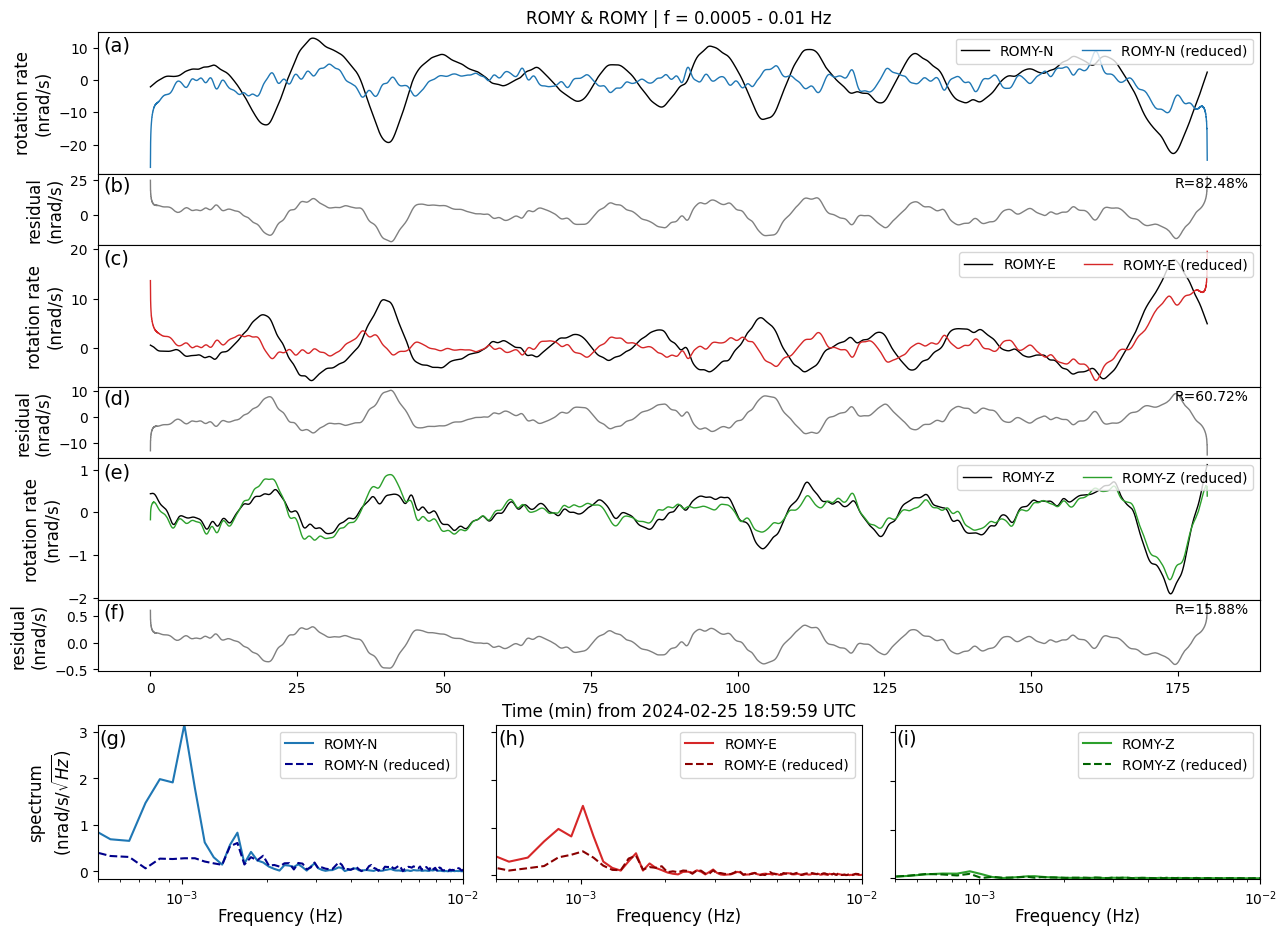

In [99]:
def __makeplot_comparison(st1, st2):

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec
    from functions.multitaper_psd import __multitaper_psd
    from functions.welch_psd import __welch_psd
    from functions.get_fft import __get_fft


    def __integrate(stt, dat):
        _st = stt.copy()
        _st.data = dat
        _st.integrate()
        return _st.data

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 4)

    def __get_residual_percent(dat1, dat2):
        imax, vmax = np.argmax(abs(dat2-dat1)), np.amax(abs(dat2-dat1))
        pmax = round(np.amax(dat2-dat1)/dat1[imax]*100, 2)
        return pmax

    def __to_dB(psd):
        return 10*np.log10(psd)

    def __get_lim(arrs):
        mins = [min(arr) for arr in arrs]
        maxs = [max(arr) for arr in arrs]
        return min(mins + maxs), max(mins + maxs)


    tscale, tunit = 1/60, "min"

    times = st1.select(channel="*N")[0].times()

    Ncol, Nrow = 6, 13

    font = 12

    lw = 1

    scale, unit = 1e9, f"nrad/s"

    fig = plt.figure(figsize=(15, 12))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0)
    gs2 = GridSpec(Nrow, Ncol, figure=fig, hspace=10000)

    ax1 = fig.add_subplot(gs[0:2, :])
    ax2 = fig.add_subplot(gs[2, :])
    ax3 = fig.add_subplot(gs[3:5, :])
    ax4 = fig.add_subplot(gs[5, :])
    ax5 = fig.add_subplot(gs[6:8, :])
    ax6 = fig.add_subplot(gs[8, :])

    ax7 = fig.add_subplot(gs2[9:12, 0:2])
    ax8 = fig.add_subplot(gs2[9:12, 2:4])
    ax9 = fig.add_subplot(gs2[9:12, 4:6])

    accN = st1.select(channel="*N")[0].data*scale
    accE = st1.select(channel="*E")[0].data*scale
    accZ = st1.select(channel="*Z")[0].data*scale

    accN_c = st2.select(channel="*N")[0].data*scale
    accE_c = st2.select(channel="*E")[0].data*scale
    accZ_c = st2.select(channel="*Z")[0].data*scale

    # psd before and after
    dt = st1.select(channel="*N")[0].stats.delta
    # fN1, psdN1 = __multitaper_psd(accN/scale, dt, n_win=5, time_bandwidth=3.0)
    # fN2, psdN2 = __multitaper_psd(accN_c/scale, dt, n_win=5, time_bandwidth=3.0)
    # fE1, psdE1 = __multitaper_psd(accE/scale, dt, n_win=5, time_bandwidth=3.0)
    # fE2, psdE2 = __multitaper_psd(accE_c/scale, dt, n_win=5, time_bandwidth=3.0)

#     fN1, psdN1 = __welch_psd(accN/scale, dt, twin_sec=150)
#     fN2, psdN2 = __welch_psd(accN_c/scale, dt, twin_sec=150)
#     fE1, psdE1 = __welch_psd(accE/scale, dt, twin_sec=150)
#     fE2, psdE2 = __welch_psd(accE_c/scale, dt, twin_sec=150)
#     fZ1, psdZ1 = __welch_psd(accZ/scale, dt, twin_sec=150)
#     fZ2, psdZ2 = __welch_psd(accZ_c/scale, dt, twin_sec=150)

    win = "hann" # "hann"

    psdN1, fN1, _ = __get_fft(accN/scale, dt, window=win)
    psdN2, fN2, _ = __get_fft(accN_c/scale, dt, window=win)
    psdE1, fE1, _ = __get_fft(accE/scale, dt, window=win)
    psdE2, fE2, _ = __get_fft(accE_c/scale, dt, window=win)
    psdZ1, fZ1, _ = __get_fft(accZ/scale, dt, window=win)
    psdZ2, fZ2, _ = __get_fft(accZ_c/scale, dt, window=win)


    ax1.plot(times*tscale, accN, color="black", label="ROMY-N", lw=lw)
    ax1.plot(times*tscale, accN_c, color="tab:blue", label=f"ROMY-N (reduced)", lw=lw)

    ax2.plot(times*tscale, (accN-accN_c), color="grey", label=f"R", lw=lw)


    ax3.plot(times*tscale, accE, color="black", label="ROMY-E", lw=lw)
    ax3.plot(times*tscale, accE_c, color="tab:red", label=f"ROMY-E (reduced)", lw=lw)

    ax4.plot(times*tscale, (accE-accE_c), color="grey", label=f"R", lw=lw)

    ax5.plot(times*tscale, accZ, color="black", label="ROMY-Z", lw=lw)
    ax5.plot(times*tscale, accZ_c, color="tab:green", label=f"ROMY-Z (reduced)", lw=lw)

    ax6.plot(times*tscale, (accZ-accZ_c), color="grey", label=f"R", lw=lw)


    ax7.plot(fN1, psdN1*1e9, label="ROMY-N", color="tab:blue")
    ax7.plot(fN2, psdN2*1e9, label=f"ROMY-N (reduced)", color="darkblue", ls="--")
    # ax7.fill_between(fN2, __to_dB(psdN1), __to_dB(psdN2), color="tab:blue", alpha=0.3)

    ax8.plot(fE1, psdE1*1e9, label="ROMY-E", color="tab:red")
    ax8.plot(fE2, psdE2*1e9, label=f"ROMY-E (reduced)", color="darkred", ls="--")
    # ax8.fill_between(fN2, __to_dB(psdE1), __to_dB(psdE2), color="tab:red", alpha=0.3)

    ax9.plot(fZ1, psdZ1*1e9, label="ROMY-Z", color="tab:green")
    ax9.plot(fZ2, psdZ2*1e9, label=f"ROMY-Z (reduced)", color="darkgreen", ls="--")
    # ax9.fill_between(fZ2, __to_dB(psdZ1), __to_dB(psdZ2), color="tab:red", alpha=0.3)

    y_max = max([max(psdN1), max(psdE1), max(psdZ1)]) * scale

    for ax in [ax7, ax8, ax9]:
        ax.set_xscale("log")
        # ax.set_yscale("log")
        ax.set_xlim(fmin, fmax)
        ax.legend(loc=1, ncol=1)
        # ax.set_xticklabels([])
        ax.set_ylim(top=y_max)
        ax.set_xlabel(f"Frequency (Hz)", fontsize=font, labelpad=0)

    ax8.tick_params(labelleft=False, left=True)
    ax9.tick_params(labelleft=False, left=True)


    for ax in [ax1, ax3, ax5]:
        ax.legend(loc=1, ncol=2)

    ax1.set_ylabel(f"rotation rate\n({unit})", fontsize=font)
    ax3.set_ylabel(f"rotation rate\n({unit})", fontsize=font)
    ax5.set_ylabel(f"rotation rate\n({unit})", fontsize=font)
    # ax7.set_ylabel(f"PSD\n(dB wrt 1 rad$^2$/s$^2$/Hz)", fontsize=font)
    sqrt=r"$\sqrt{Hz}$"
    ax7.set_ylabel(f"spectrum\n(nrad/s/{sqrt})", fontsize=font)

    ax2.set_ylabel(f"residual\n({unit})", fontsize=font)
    ax4.set_ylabel(f"residual\n({unit})", fontsize=font)
    ax6.set_ylabel(f"residual\n({unit})", fontsize=font)

    for ax in [ax1, ax2, ax3, ax5]:
        ax.get_xaxis().set_visible(False)

    ax6.set_xlabel(f"Time ({tunit}) from {st1[0].stats.starttime.date} {str(st1[0].stats.starttime.time).split('.')[0]} UTC", fontsize=font, labelpad=5)

    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)
    ax3.text(.005, .97, "(c)", ha='left', va='top', transform=ax3.transAxes, fontsize=font+2)
    ax4.text(.005, .97, "(d)", ha='left', va='top', transform=ax4.transAxes, fontsize=font+2)
    ax5.text(.005, .97, "(e)", ha='left', va='top', transform=ax5.transAxes, fontsize=font+2)
    ax6.text(.005, .97, "(f)", ha='left', va='top', transform=ax6.transAxes, fontsize=font+2)
    ax7.text(.005, .97, "(g)", ha='left', va='top', transform=ax7.transAxes, fontsize=font+2)
    ax8.text(.005, .97, "(h)", ha='left', va='top', transform=ax8.transAxes, fontsize=font+2)
    ax9.text(.005, .97, "(i)", ha='left', va='top', transform=ax9.transAxes, fontsize=font+2)

    txt = f"R={__variance_reduction(accN, accN_c)}%"
    ax2.text(.99, .97, txt, ha='right', va='top', transform=ax2.transAxes, fontsize=font-2)

    txt = f"R={__variance_reduction(accE, accE_c)}%"
    ax4.text(.99, .97, txt, ha='right', va='top', transform=ax4.transAxes, fontsize=font-2)

    txt = f"R={__variance_reduction(accZ, accZ_c)}%"
    ax6.text(.99, .97, txt, ha='right', va='top', transform=ax6.transAxes, fontsize=font-2)

    ax1.set_title(f"{st1[0].stats.station} & {st2[0].stats.station} | f = {fmin} - {fmax} Hz")

    plt.plot();
    return fig

fig = __makeplot_comparison(st1, st2)

# fig.savefig(config['path_to_figs']+f"RB_{config['tbeg'].date}_comparison.png", format="png", dpi=150, bbox_inches='tight')


## Wind speed and direction

In [100]:
from andbro__load_FURT_stream import __load_furt_stream
from functions.smoothing import __smooth

In [101]:
furt = __load_furt_stream(config['tbeg'], config['tend'], path_to_archive=bay_path+'gif_online/FURT/WETTER/')

85.0


(array([4.600e+01, 5.300e+01, 1.310e+02, 6.700e+02, 1.967e+03, 4.294e+03,
        4.731e+03, 5.058e+03, 6.152e+03, 5.143e+03, 2.600e+03, 7.020e+02,
        1.830e+02, 7.400e+01, 4.200e+01, 5.000e+00, 4.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 3.000e+00, 1.600e+01, 1.200e+01, 1.700e+01,
        9.000e+00, 7.000e+00, 1.000e+01, 3.800e+01, 1.800e+01, 3.400e+01,
        3.400e+01, 7.000e+01, 5.700e+01, 1.700e+01, 4.400e+01, 2.600e+01]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
        110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
        220., 230., 240., 250., 260., 270., 280., 290., 300., 310., 320.,
        330., 340., 350., 360.]),
 <BarContainer object of 36 artists>)

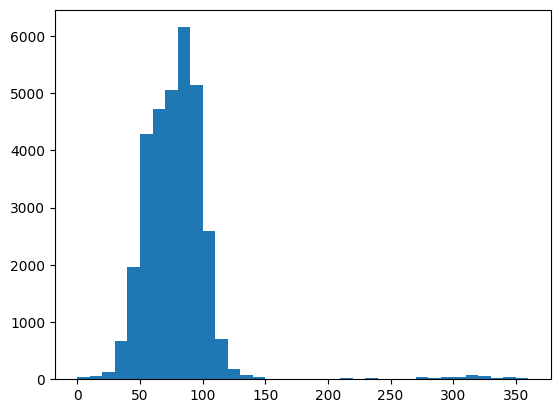

In [102]:
dx = 10

wind_dir = furt.select(channel="LAD")[0].data

wind_dir_smooth = __smooth(wind_dir, 60)

_hist = np.histogram(wind_dir_smooth, bins=int(360/dx), range=(0, 360))

wind_dir_mean = _hist[1][np.argmax(_hist[0])] + dx/2
print(wind_dir_mean)

plt.hist(furt.select(channel="LAD")[0].data, bins=36, range=(0, 360))

In [103]:
# plt.plot(wind_dir_smooth)

1.5


(array([6.5800e+02, 3.3420e+03, 1.1234e+04, 1.0919e+04, 4.2330e+03,
        1.2810e+03, 3.9100e+02, 1.5400e+02, 5.0000e+01, 8.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ]),
 <BarContainer object of 20 artists>)

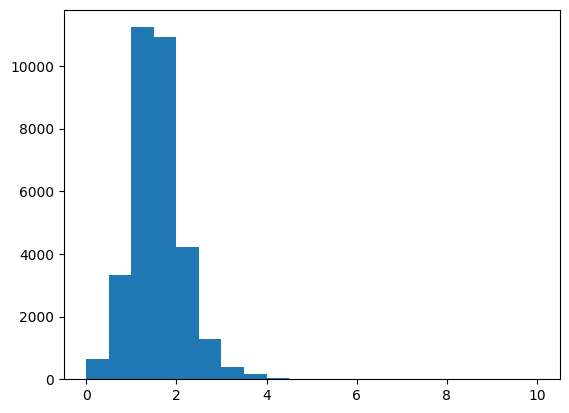

In [104]:
dx = 1

wind_vel = furt.select(channel="LAW")[0].data

wind_vel_smooth = __smooth(wind_vel, 60)

_hist = np.histogram(wind_vel_smooth, bins=int(15/dx), range=(0, 15))

wind_vel_mean = _hist[1][np.argmax(_hist[0])] + dx/2
print(wind_vel_mean)

plt.hist(furt.select(channel="LAW")[0].data, bins=20, range=(0, 10))

In [105]:
# plt.plot(wind_vel_smooth)

### Load FUR

In [106]:
stf = obs.Stream()
stf += __read_sds(config['path_to_sds2'], "GR.FUR..BHZ", config['tbeg'], config['tend'])
stf += __read_sds(config['path_to_sds2'], "GR.FUR..BHN", config['tbeg'], config['tend'])
stf += __read_sds(config['path_to_sds2'], "GR.FUR..BHE", config['tbeg'], config['tend'])

fur_inv = read_inventory(data_path+"/stationxml_ringlaser/station_GR_FUR.xml")

stf = stf.remove_response(inventory=fur_inv, output="ACC", water_level=0, pre_filt=[0.001, 0.005, 45, 50])
# stf = stf.remove_response(inventory=fur_inv, output="ACC", water_level=10)

stf = stf.merge(fill_value="interpolate")

# convert to tilt
for tr in stf:
    tr.data /= 9.81 # m/s^2

stf

3 Trace(s) in Stream:
GR.FUR..BHE | 2024-02-25T15:59:59.990000Z - 2024-02-26T00:59:59.990000Z | 20.0 Hz, 648001 samples
GR.FUR..BHN | 2024-02-25T15:59:59.989999Z - 2024-02-26T00:59:59.989999Z | 20.0 Hz, 648001 samples
GR.FUR..BHZ | 2024-02-25T15:59:59.990000Z - 2024-02-26T00:59:59.990000Z | 20.0 Hz, 648001 samples

### Compute Pressure Gradient

In [107]:
from functions.compute_baro_gradient_romy import __compute_baro_gradient_romy

In [108]:
def __compute_baro_gradient_romy(tbeg, tend, status=False, excluded_stations=[], verbose=False, freqs=None):

    ######################
    """
    rotation_X = -u_nz
    rotation_Y =  u_ez
    rotation_Z = 0.5*(u_ne-u_en)
    """
    ######################

    import os
    import numpy as np
    import timeit
    import matplotlib.pyplot as plt
    import matplotlib.colors

    from obspy import UTCDateTime, Stream, read_inventory
    from obspy.clients import fdsn
    from obspy.geodetics.base import gps2dist_azimuth
    from obspy.geodetics import locations2degrees
    from obspy.clients.fdsn import Client, RoutingClient
    from obspy.signal import array_analysis as AA
    from obspy.signal.util import util_geo_km
    from obspy.signal.rotate import rotate2zne
    from datetime import datetime

    import warnings
    warnings.filterwarnings('ignore')

    if os.uname().nodename == 'lighthouse':
        root_path = '/home/andbro/'
        data_path = '/home/andbro/kilauea-data/'
        archive_path = '/home/andbro/freenas/'
        bay_path = '/home/andbro/ontap-ffb-bay200/'
        lamont_path = '/home/andbro/lamont/'
    elif os.uname().nodename == 'kilauea':
        root_path = '/home/brotzer/'
        data_path = '/import/kilauea-data/'
        archive_path = '/import/freenas-ffb-01-data/'
        bay_path = '/import/ontap-ffb-bay200/'
        lamont_path = '/lamont/'
    elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
        root_path = '/home/brotzer/'
        data_path = '/import/kilauea-data/'
        archive_path = '/import/freenas-ffb-01-data/'
        bay_path = '/import/ontap-ffb-bay200/'
        lamont_path = '/lamont/'

    # _____________________________________________________

    # start timer for runtime
    start_timer = timeit.default_timer()

    # _____________________________________________________

    # generate configuration object
    config = {}

    # convert to utcdatetime object
    config['tbeg'] = UTCDateTime(tbeg)
    config['tend'] = UTCDateTime(tend)

    # select the fdsn client for the stations
    # config['fdsn_client'] = {"BW":Client('http://jane'), "GR":Client('BGR')}
    config['fdsn_client'] = {"BW":Client('LMU'), "GR":Client('BGR')}

    # define output seed
    config['out_seed'] = "BW.BRMY"

    config['location'] = "00"

    # specify frequency range
    if freqs is None:
        config['freq2'] = 0.01
        config['freq1'] = 0.0001
    else:
        config['freq2'] = freqs['fmax']
        config['freq1'] = freqs['fmin']

    config['apply_bandpass'] = True

    # decide if information is printed while running the code
    config['verbose'] = verbose

    # BRMY array information
    config['array_stations'] = [
                               'BW.PROMY.03.LDI',
                               'BW.GELB..LDO',
                               'BW.GRMB..LDO',
                               'BW.ALFT..LDO',
                               'BW.BIB..LDO',
                               'BW.TON..LDO',
                                ]

    # specify reference station
    config['reference_station'] = 'BW.PROMY.03.LDI'

    # exclude stations
    config['subarray_stations'] = [_sta for _sta in config['array_stations'] if _sta not in excluded_stations]

    # create subarray mask
    config['subarray_mask'] = range(len(config['subarray_stations']))

    # set coordinates
    config['coo'] = {  "ALFT":{"lon":11.2795 , "lat":48.142334, "height":593.0},
                       "GELB":{"lon":11.2514 , "lat":48.1629, "height":628.0},
                       "GRMB":{"lon":11.2635 , "lat":48.1406, "height":656.0},
                       "TON":{"lon":11.288809 , "lat":48.173897, "height":564.0},
                       "BIB":{"lon":11.2473 , "lat":48.1522, "height":599.0},
                       "PROMY":{"lon":11.275501 , "lat":48.162941, "height":571.0},
                      }

    # adr parameters
    config['vp'] = 1 # 5000 #6264. #1700
    config['vs'] = 1 # 3500 #3751. #1000
    config['sigmau'] = 1e-7 # 0.0001

    # _____________________________________________________

    def __interpolate_nan(array_like):

        from numpy import isnan, interp

        array = array_like.copy()

        nans = isnan(array)

        def get_x(a):
            return a.nonzero()[0]

        array[nans] = interp(get_x(nans), get_x(~nans), array[~nans])

        return array

    def __read_sds(path_to_archive, seed, tbeg, tend, data_format="MSEED"):

        '''
        VARIABLES:
         - path_to_archive
         - seed
         - tbeg, tend
         - data_format

        DEPENDENCIES:
         - from obspy.core import UTCDateTime
         - from obspy.clients.filesystem.sds import Client

        OUTPUT:
         - stream

        EXAMPLE:
        >>> st = __read_sds(path_to_archive, seed, tbeg, tend, data_format="MSEED")

        '''

        import os
        from obspy.core import UTCDateTime, Stream
        from obspy.clients.filesystem.sds import Client

        tbeg, tend = UTCDateTime(tbeg), UTCDateTime(tend)

        if not os.path.exists(path_to_archive):
            print(f" -> {path_to_archive} does not exist!")
            return

        ## separate seed id
        net, sta, loc, cha = seed.split(".")

        ## define SDS client
        client = Client(path_to_archive, sds_type='D', format=data_format)

        ## read waveforms
        try:
            st = client.get_waveforms(net, sta, loc, cha, tbeg, tend, merge=-1)
        except:
            print(f" -> failed to obtain waveforms!")
            st = Stream()

        return st

    def __get_inventory_and_distances(config):

        coo = []
        for i, station in enumerate(config['subarray_stations']):

            net, sta, _, _ = station.split(".")

            loc, cha = "", "*HZ"

            # change PROMY
            if sta == "PROMY":
                sta, cha = "ROMY", "*JN"

            try:
                inven = config['fdsn_client'][net].get_stations(
                                                                network=net,
                                                                station=sta,
                                                                channel=cha,
                                                                location=loc,
                                                                starttime=config['tbeg'],
                                                                endtime=config['tend'],
                                                                level='response'
                                                                )
            except:
                return [], []
                print("fail")

            # get coordinates
            l_lon =  float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['longitude'])
            l_lat =  float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['latitude'])
            height = float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['elevation'])

            print(l_lon, l_lat, height)

            if station == config['reference_station']:
                o_lon, o_lat, o_height = l_lon, l_lat, height

            lon, lat = util_geo_km(o_lon, o_lat, l_lon, l_lat)

            # convert unit from km to m
            coo.append([lon*1000, lat*1000, height-o_height])

        return inven, np.array(coo)

    def __check_samples_in_stream(st, config):

        Rnet, Rsta, _, _ = config['reference_station'].split(".")

        Rsamples = st.select(network=Rnet, station=Rsta)[0].stats.npts

        for tr in st:
            if tr.stats.npts != Rsamples:
                print(f" -> removing {tr.stats.station} due to improper number of samples ({tr.stats.npts} not {Rsamples})")
                st.remove(tr)

        return st

    def __get_data(config):

        config['subarray'] = []

        st = Stream()

        for k, station in enumerate(config['subarray_stations']):

            net, sta, loc, cha = station.split(".")

            print(f" -> requesting {net}.{sta}.{loc}.{cha}") if config['verbose'] else None

            # try to get waveform data
            try:
                st00 = __read_sds(archive_path+"temp_archive/", station, config['tbeg'], config['tend'])
                # print(data)

            except Exception as E:
                print(E) if config['verbose'] else None
                print(f" -> getting waveforms failed for {net}.{sta}.{loc}.{cha} ...")
                del config['coo'][sta]
                continue

            # # check if empty
            if len(st00) == 0:
                print(f" -> stream empty.")
                del config['coo'][sta]
                continue

            # merge if masked
            if len(st00) > 1:
                print(f" -> merging stream. Length: {len(st00)} -> 1") if config['verbose'] else None
                st00 = st00.merge(method=1, fill_value="interpolate")

            # interpolate nan values
            for tr in st00:
                if np.isnan(tr.data).any():
                    print(" -> NaN found")
                    tr.data = __interpolate_nan(tr.data)

            # successfully obtained
            if len(st00) == 3:
                print(f" -> obtained: {net}.{sta}")

            # correect scaling for PROMY.03
            if sta == "PROMY" and loc == "03":
                for tr in st00:
                    tr.data /= 100

            # resampling using decitmate
            st00 = st00.detrend("linear");

            # assign reference station stream
            if station == config['reference_station']:
                # ref_station = stats.copy().resample(40, no_filter=False)
                ref_station = st00.copy()

            # add to stream
            st += st00

            print(st00)
            # create station list for obtained stations
            config['subarray'].append(f"{st00[0].stats.network}.{st00[0].stats.station}")

        if verbose:
            st.plot(equal_scale=False);

        # update subarray stations
        config['subarray_stations'] = config['subarray']

        print(f" -> obtained: {len(st)} of {len(config['subarray_stations'])} stations!") if config['verbose'] else None

        if len(st) == 0:
            del config['coo'][station]
            return st, Stream(), config
        else:
            return st, ref_station, config

    def __compute_ADR(st, config, ref_station):

        # prepare data arrays
        tsz, tsn, tse = [], [], []
        for tr in st:
            try:
                if "Z" in tr.stats.channel:
                    tsz.append(tr.data)
                elif "N" in tr.stats.channel:
                    tsn.append(tr.data)
                elif "E" in tr.stats.channel:
                    tse.append(tr.data)
            except:
                print(" -> stream data could not be appended!")

        # make sure input is array type
        tse, tsn, tsz = np.array(tse), np.array(tsn), np.array(tsz)

        # define array for subarray stations with linear numbering
        substations = np.arange(len(config['subarray_stations']))

        try:
            result = AA.array_rotation_strain(substations,
                                              np.transpose(tse),
                                              np.transpose(tsn),
                                              np.transpose(tsz),
                                              config['vp'],
                                              config['vs'],
                                              config['dist'],
                                              config['sigmau'],
                                             )
        except Exception as E:
            print(E)
            print("\n -> failed to compute ADR...")
            return None

        # create rotation stream and add data
        out = Stream()
        out += ref_station.copy()
        out += ref_station.copy()
        out += ref_station.copy()

        out[0].data = result['ts_w3']
        out[1].data = result['ts_w2']
        out[2].data = result['ts_w1']

        out[0].stats.channel = 'BDZ'
        out[1].stats.channel = 'BDN'
        out[2].stats.channel = 'BDE'

        out[0].stats.station = config['out_seed'].split(".")[1]
        out[1].stats.station = config['out_seed'].split(".")[1]
        out[2].stats.station = config['out_seed'].split(".")[1]

        out[0].stats.network = config['out_seed'].split(".")[0]
        out[1].stats.network = config['out_seed'].split(".")[0]
        out[2].stats.network = config['out_seed'].split(".")[0]

        out[0].stats.location = config['location']
        out[1].stats.location = config['location']
        out[2].stats.location = config['location']

        out = out.detrend('linear')

        return out

    def __adjust_time_line(st0, reference="BW.ROMY"):

        Rnet, Rsta, _, _ = reference.split(".")

        ref_start = st0.select(network=Rnet, station=Rsta)[0].stats.starttime
        ref_times = st0.select(network=Rnet, station=Rsta)[0].times()

        dt = st0.select(network=Rnet, station=Rsta)[0].stats.delta

        for tr in st0:
            times = tr.times(reftime=ref_start)

            tr.data = np.interp(ref_times, times, tr.data)
            tr.stats.starttime = ref_start

        return st0

    # __________________________________________________________
    # MAIN

    # launch a times
    start_timer1 = timeit.default_timer()

    # status of stations loaded
    config['stations_loaded'] = np.ones(len(config['subarray_stations']))

    # request data for pfo array
    st, ref_station, config = __get_data(config)

    # get inventory and coordinates/distances
    # inv, config['coo'] = __get_inventory_and_distances(config)

    # update coordinates
    for _sta in config['subarray_stations']:
        if _sta not in config['subarray']:
            print(_sta)
            del config['coo'][_sta]

    for tr in st:
        tr.stats.channel = "LDZ"

    # add placebo N component
    _stN = st.copy()
    for tr in _stN:
        tr.stats.channel = "LDN"

    # add placebo E component
    _stE = st.copy()
    for tr in _stE:
        tr.stats.channel = "LDE"

    st += _stN.copy()
    st += _stE.copy()

    # processing
    st = st.detrend("linear")
    st = st.detrend("demean")

    # bandpass filter
    if config['apply_bandpass']:
        st = st.taper(0.02, type="cosine")
        st = st.filter('bandpass', freqmin=config['freq1'], freqmax=config['freq2'], corners=4, zerophase=True)
        print(f" -> bandpass: {config['freq1']} - {config['freq2']} Hz")

    # compute relataive distances
    dist = []
    for k in config['coo'].keys():

        coo = config['coo'][k]

        ref_sta = config['reference_station'].split(".")[1]

        # reference
        ref = config['coo'][ref_sta]
        ref_lon, ref_lat, ref_height = ref['lon'], ref['lat'], ref['height']

        # convert
        lon, lat = util_geo_km(ref_lon, ref_lat, coo['lon'], coo['lat'])

        # convert unit from km to m
        dist.append([lon*1000, lat*1000, coo['height']-ref_height])

    config['dist'] = np.array(dist)

    # plot station coordinates for check up
    if verbose:
        import matplotlib.pyplot as plt
        for station in config['subarray_stations']:
            print(station)
            _net, _sta = station.split(".")
            plt.scatter(config['coo'][_sta]['lon'], config['coo'][_sta]['lat'], label=_sta)
            plt.legend()
        plt.show();

    # check if enough stations for ADR are available otherwise continue
    if len(st) < 3*3:
        print(" -> not enough stations (< 3) for ADR computation!")
        return
    else:
        print(f" -> continue computing ADR for {int(len(st)/3)} of {len(config['subarray_mask'])} stations ...")

    # homogenize the time line
    # st = __adjust_time_line(st, reference=config['reference_station'])

    # trim to requested interval
    # st = st.trim(config['tbeg'], config['tend'])

    # check for same amount of samples
    __check_samples_in_stream(st, config)

    # compute array derived rotation (ADR)
    try:
        rot = __compute_ADR(st, config, ref_station)
    except Exception as e:
        print(e)
        # return None

    # get mean starttime
    # tstart = [tr.stats.starttime - tbeg for tr in st]
    # for tr in st:
    #     tr.stats.starttime = tbeg + np.mean(tstart)

    # trim to requested interval
    rot = rot.trim(config['tbeg'], config['tend'])

    # remove Z trace (not possible to compute for pressure)
    for tr in rot:
        if "Z" in tr.stats.channel:
            rot.remove(tr);

    # stop times
    stop_timer1 = timeit.default_timer()
    print(f"\n -> Runtime: {round((stop_timer1 - start_timer1)/60, 2)} minutes\n")

    return rot

In [109]:
bgrad = __compute_baro_gradient_romy(config['tbeg'],
                                     config['tend'],
                                     status=False,
                                     excluded_stations=[],
                                     verbose=False,
                                     freqs={'fmin':0.0001, 'fmax':0.001},
                                    )

1 Trace(s) in Stream:
BW.PROMY.03.LDI | 2024-02-25T16:00:00.000000Z - 2024-02-26T01:00:00.000000Z | 1.0 Hz, 32401 samples
1 Trace(s) in Stream:
BW.GELB..LDO | 2024-02-26T00:00:00.000000Z - 2024-02-26T01:00:00.000000Z | 1.0 Hz, 3601 samples
1 Trace(s) in Stream:
BW.GRMB..LDO | 2024-02-25T16:00:00.000000Z - 2024-02-26T01:00:00.000000Z | 1.0 Hz, 32401 samples
1 Trace(s) in Stream:
BW.ALFT..LDO | 2024-02-25T16:00:00.000000Z - 2024-02-26T01:00:00.000000Z | 1.0 Hz, 32401 samples
 -> stream empty.
 -> stream empty.
 -> bandpass: 0.0001 - 0.001 Hz
 -> continue computing ADR for 4 of 6 stations ...
 -> removing GELB due to improper number of samples (3601 not 32401)
 -> removing GELB due to improper number of samples (3601 not 32401)
 -> removing GELB due to improper number of samples (3601 not 32401)
ts1 has 3 columns(stations) but array_coords has 4 rows(stations)

 -> failed to compute ADR...


AttributeError: 'NoneType' object has no attribute 'trim'

In [ ]:
stb = obs.Stream()

stb += stf.copy()
stb += til1.copy()
stb += ffbi0.copy()
stb += sth.copy()
stb += bgrad.copy()

# fmin, fmax, code = 0.005, 0.01, "hf"
fmin, fmax, code = 0.0005, 0.01, "lf"

stb = stb.detrend("demean")
stb = stb.detrend("linear")
stb = stb.taper(0.05, type="cosine")

stb = stb.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True);

stb = stb.trim(config['t1'], config['t2'])

# for tr in stb:
#     tr.data = tr.data[:-1]


# stb.plot(equal_scale=False);


In [ ]:
from functions.find_max_min import __find_max_min

In [ ]:
def __makeplot6():

    from scipy.signal import hilbert
    from numpy import imag

    Nrow, Ncol = 7, 1

    yscale = 1e9

    fscale = 1

    gscale = 1e5

    font = 12

    ch = "*DO"

    tscale, tunit = 1/3600, "hours"

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 12), sharex=True)

    ax[0].plot(stb.select(station="ROMY", component="Z")[0].times(reftime=config['tbeg'])*tscale,
               stb.select(station="ROMY", component="Z")[0].data*yscale,
               label="ROMY.Z", color="tab:blue")
    ax[0].plot(stb.select(station="FUR", component="Z")[0].times(reftime=config['tbeg'])*tscale,
               stb.select(station="FUR", component="Z")[0].data*yscale*fscale,
               label="FUR.Z", color="k", ls="-")

    ax[1].plot(stb.select(station="ROMY", component="N")[0].times(reftime=config['tbeg'])*tscale,
               stb.select(station="ROMY", component="N")[0].data*yscale,
               label="ROMY.N", color="tab:orange")
    ax[1].plot(stb.select(station="FUR", component="E")[0].times(reftime=config['tbeg'])*tscale,
               stb.select(station="FUR", component="E")[0].data*yscale*fscale,
               label="FUR.E", color="k", ls="-")

    ax[2].plot(stb.select(station="ROMY", component="E")[0].times(reftime=config['tbeg'])*tscale,
               stb.select(station="ROMY", component="E")[0].data*yscale,
               label="ROMY.E", color="tab:red")
    ax[2].plot(stb.select(station="FUR", component="N")[0].times(reftime=config['tbeg'])*tscale,
               stb.select(station="FUR", component="N")[0].data*yscale*fscale,
               label="FUR.N", color="k", ls="-")

    ax[3].plot(stb.select(channel="LDO")[0].times(reftime=config['tbeg'])*tscale,
               stb.select(channel="LDO")[0].data,
               label=f"FFBI.O", color="k")

    ax[4].plot(stb.select(channel="LDH")[0].times(reftime=config['tbeg'])*tscale,
               stb.select(channel="LDH")[0].data,
               label=f"Hilbert(FFBI.O)", color="darkgrey")

    ax[5].plot(stb.select(channel="BDN")[0].times(reftime=config['tbeg'])*tscale,
               stb.select(channel="BDN")[0].data*gscale,
               label=f"BGRD.N", color="tab:purple")

    ax[6].plot(stb.select(channel="BDE")[0].times(reftime=config['tbeg'])*tscale,
               stb.select(channel="BDE")[0].data*gscale,
               label=f"BGRD.E", color="tab:pink")

    for _n in range(Nrow):
        # ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)
        ax[_n].spines[['right', 'top']].set_visible(False)
        if _n < Nrow-1:
            ax[_n].spines[['bottom']].set_visible(False)

    ax[0].set_ylabel("Tilt\n(nrad)", fontsize=font)
    ax[1].set_ylabel("Tilt\n(nrad)", fontsize=font)
    ax[2].set_ylabel("Tilt\n(nrad)", fontsize=font)

    ax[3].set_ylabel("Pressure\n(Pa)", fontsize=font)
    ax[4].set_ylabel("Pressure\n(Pa)", fontsize=font)

    ax[5].set_ylabel("Spatial\nGradient\n(Pa/km)", fontsize=font)
    ax[6].set_ylabel("Spatial\nGradient\n(Pa/km)", fontsize=font)

    ax[Nrow-1].set_xlabel(f"Time ({tunit}) since {config['tbeg'].date}  {str(config['tbeg'].time)[:9]} UTC", fontsize=font)

    ax[0].set_title(f"{fmin} - {fmax} Hz")

    for _k, ll in enumerate(['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)

    plt.show();
    return fig

fig = __makeplot6();

fig.savefig(config['path_to_figs']+f"RB_{config['tbeg'].date}_{code}_waveforms_gradient.png", format="png", dpi=150, bbox_inches='tight')
